Code for characterizing the final IntAct database we collected. 
* Foldability of the proteins
* How well-studied the protiens are 
* Presence in DisProt
* Coverage of protein families 
* Length distribution
* Species distribution
* MI term distribution
* Proportion of single, multi, deletion, insertion mutants
* Proportion of binding site-altered negatives 
* How many unique proteins have associated negative interactions
* Distribution of MI scores 
* Are there cases of isoform specificity? (where one isoform is positive, and another is negative, for a given protein?) If not, can I infer it from binding sites?

Make conclusions about things to consider in my splits
* Node degree (by pos PPIs)
* Node degree (by # PubMed IDs)
* MI score (maybe try to upsample better MI scores in the test set)


# Imports

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from matplotlib.colors import LogNorm
from scipy.stats import spearmanr, pearsonr
import matplotlib.font_manager as fm
from matplotlib.font_manager import FontProperties
import statsmodels.api as sm

# -------------------------------------------------
# Set Ubuntu font from utils/ubuntu_font/*.ttf
# -------------------------------------------------
def set_font():
    # Load and set the font
    # Get the directory where this script lives
    font_dir = "/scratch/pranamlab/sophie/interactome/interactome/utils/ubuntu_font"

    # Paths for regular, bold, italic fonts
    regular_font_path = os.path.join(font_dir, "Ubuntu-Regular.ttf")
    bold_font_path = os.path.join(font_dir, "Ubuntu-Bold.ttf")
    italic_font_path = os.path.join(font_dir, "Ubuntu-Italic.ttf")
    bold_italic_font_path = os.path.join(font_dir, "Ubuntu-BoldItalic.ttf")

    # Load the font properties
    regular_font = FontProperties(fname=regular_font_path)
    bold_font = FontProperties(fname=bold_font_path)
    italic_font = FontProperties(fname=italic_font_path)
    bold_italic_font = FontProperties(fname=bold_italic_font_path)

    # Add the fonts to the font manager
    fm.fontManager.addfont(regular_font_path)
    fm.fontManager.addfont(bold_font_path)
    fm.fontManager.addfont(italic_font_path)
    fm.fontManager.addfont(bold_italic_font_path)

    # Set the font family globally to Ubuntu
    plt.rcParams["font.family"] = regular_font.get_name()

    # Set the font family globally to Ubuntu
    plt.rcParams["font.family"] = regular_font.get_name()
    plt.rcParams["mathtext.fontset"] = "custom"
    plt.rcParams["mathtext.rm"] = regular_font.get_name()
    plt.rcParams["mathtext.it"] = italic_font.get_name()
    plt.rcParams["mathtext.bf"] = bold_font.get_name()

set_font()

# Seaborn theme tuned for publication
sns.set_theme(
    style="white",
    context="paper",
)



# Temp (scrap)

In [2]:
savedir = "/scratch/pranamlab/sophie/interactome/interactome/data_files/processed/intact/clean"

pos = pd.read_csv(f"{savedir}/mi0407_ptm_and_mut_and_bindsite.csv")

unknown = pd.read_csv(f"{savedir}/mi0407_unknown_ptm_and_mut_and_bindsite.csv")

neg = pd.read_csv(f"{savedir}/mi0407_neg_ptm_and_mut_and_bindsite.csv")

simplemerged_dtypes = {k: "string" for k in pos.columns}
simplemerged_dtypes["Negative"] = "str"
#simplemerged_dtypes["length_1"] = "int"
#simplemerged_dtypes["length_2"] = "int"
simplemerged_dtypes["miscore"] = "float"
simplemerged_dtypes["year"] = "int"
simplemerged_dtypes["confidence_val_int"] = "float"
simplemerged_dtypes["unique_score_int"] = "float"

pos = pd.read_csv(f"{savedir}/mi0407_ptm_and_mut_and_bindsite.csv", dtype=simplemerged_dtypes)

unknown = pd.read_csv(f"{savedir}/mi0407_unknown_ptm_and_mut_and_bindsite.csv",dtype=simplemerged_dtypes)

neg = pd.read_csv(f"{savedir}/mi0407_neg_ptm_and_mut_and_bindsite.csv",dtype=simplemerged_dtypes)

/tmp/ipykernel_435860/3201253924.py:3: DtypeWarning: Columns (18,19,62,63,64,65,70,71,72,73,94,96,143,199,205,218,219) have mixed types. Specify dtype option on import or set low_memory=False.
  pos = pd.read_csv(f"{savedir}/mi0407_ptm_and_mut_and_bindsite.csv")
/tmp/ipykernel_435860/3201253924.py:5: DtypeWarning: Columns (18,19,62,63,64,65,66,67,68,69,70,71,72,73,74,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,121,142,151,152,159,160,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,209,210,211,212,213,214,215,218,219,220,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,269,270,271,272,273,274,275,276,279,280,281,282) have mixed types. Specify dtype option on impo

In [3]:
pos["Negative"] = False
neg["Negative"] = True
unknown["Negative"] = False

pos["length_1"] = pos["aa_1"].apply(lambda x: len(x) if pd.notna(x) else 0)
pos["length_2"] = pos["aa_2"].apply(lambda x: len(x) if pd.notna(x) else 0)

neg["length_1"] = neg["aa_1"].apply(lambda x: len(x) if pd.notna(x) else 0)
neg["length_2"] = neg["aa_2"].apply(lambda x: len(x) if pd.notna(x) else 0)

unknown["length_1"] = unknown["aa_1"].apply(lambda x: len(x) if pd.notna(x) else 0)
unknown["length_2"] = unknown["aa_2"].apply(lambda x: len(x) if pd.notna(x) else 0)

In [4]:
def harmonize_nulls_to_nan(df: pd.DataFrame, *, also_blank_strings=True, keep_datetime=False) -> pd.DataFrame:
    out = df.copy()

    # 1) Convert common sentinels to real missing
    if also_blank_strings:
        out = out.replace({"": pd.NA, "None": pd.NA, "nan": pd.NA})

    # 2) Normalize to pandas NA first (unifies None/NaN/<NA>)
    out = out.convert_dtypes()

    # 3) Cast extension dtypes -> object so np.nan can live there.
    for c in out.columns:
        dt = out[c].dtype
        is_ext = isinstance(dt, pd.api.extensions.ExtensionDtype)
        if keep_datetime and pd.api.types.is_datetime64_any_dtype(dt):
            # keep datetimes as datetime64 with NaT
            continue
        if is_ext:
            out[c] = out[c].astype(object)

    # 4) Finally: make ALL missings = np.nan
    out = out.where(~out.isna(), np.nan)

    return out

In [5]:
pos = harmonize_nulls_to_nan(pos)
neg = harmonize_nulls_to_nan(neg)
unknown = harmonize_nulls_to_nan(unknown)

## gene2pubmed

Seeing how well-studied everything is using the `data_files/raw/gene2pubmed/gene2pubmed` file

```
#tax_id GeneID  PubMed_ID
24      67441593        1779750
24      67441593        16753031
24      67441593        21620858
24      67441594        21219854
```

In [6]:
[x for x in pos.columns if "gene" in x]

['gene_symbol_1',
 'gene_symbol_2',
 'uniprot_gene_name_A',
 'uniprot_gene_name_B']

In [7]:
# get all unique UniProt IDs
display(pos[["uniprot_A","uniprot_B","gene_symbol_1","gene_symbol_2","species_taxid_1", "species_taxid_2"]].head())

all_uniprots = pos["uniprot_A"].tolist() + pos["uniprot_B"].tolist()
all_uniprots+= (neg["uniprot_A"].tolist() + neg["uniprot_B"].tolist())
all_uniprots+= (unknown["uniprot_A"].tolist() + unknown["uniprot_B"].tolist())
all_uniprots = set([x.split("uniprotkb:")[1].split("-")[0].split("_")[0] for x in all_uniprots if pd.notna(x)])
print(f"Total unique uniprot IDs: {len(all_uniprots):,}")
s = "\n".join(list(all_uniprots))
with open("data_files/processed/intact/features/all_final_uniprots.txt", "w") as f:
    f.write(s)
    
all_gene_symbols = pos["gene_symbol_1"].tolist() + pos["gene_symbol_2"].tolist()
all_gene_symbols+= (neg["gene_symbol_1"].tolist() + neg["gene_symbol_2"].tolist())
all_gene_symbols+= (unknown["gene_symbol_1"].tolist() + unknown["gene_symbol_2"].tolist())
all_gene_symbols = set([x for x in all_gene_symbols if pd.notna(x)])
print(f"Total unique gene_symbols: {len(all_gene_symbols):,}")
s = "\n".join(list(all_gene_symbols))
with open("data_files/processed/intact/features/all_final_gene_symbols.txt", "w") as f:
    f.write(s)

,uniprot_A,uniprot_B,gene_symbol_1,gene_symbol_2,species_taxid_1,species_taxid_2
0,uniprotkb:P80667-0,uniprotkb:A0A023PZD0-0,PEX13,NaN,559292,559292
1,uniprotkb:Q8VDF2-0,uniprotkb:C0HKE2-0,Uhrf1,H2ac4,10090,10090
2,uniprotkb:P38041-0,uniprotkb:C8Z569-0,BOI1,NaN,559292,643680
3,uniprotkb:Q9UKI8-0,uniprotkb:O00161-0,TLK1,SNAP23,9606,9606
4,uniprotkb:Q15418-0,uniprotkb:O00418-0,RPS6KA1,EEF2K,9606,9606


Total unique uniprot IDs: 14,232
Total unique gene_symbols: 12,026


In [8]:
# read the IDMapping result
idmapping = pd.read_csv("data_files/processed/intact/idmapping/uniprot_to_geneid_idmapping_2025_12_11.tsv",sep="\t")
idmapping.head()

,From,To
0,B4FXU9,100273859
1,B6SJ20,100274775
2,Q9GZH3,177457
3,Q94207,177422
4,P74860,1252936


In [9]:
display(idmapping.groupby("From").agg({'To':'nunique'})['To'].value_counts().reset_index())
display(idmapping.groupby("To").agg({'From':'nunique'})['From'].value_counts().reset_index())

,To,count
0,1,61324
1,2,1292
2,3,19
3,4,7
4,5,7
5,23,4
6,17,3
7,13,3
8,8,3
9,12,2


,From,count
0,1,62048
1,2,1031
2,3,68
3,5,6
4,4,5


In [10]:
from collections import defaultdict
import pandas as pd

# 1. Build gene_to_pmids: GeneID -> set(PMID)
gene_to_pmids = defaultdict(set)

with open("data_files/raw/gene2pubmed/gene2pubmed") as f:
    for line in f:
        if line.startswith("#"):
            continue
        tax, gene, pmid = line.strip().split()
        gene_to_pmids[gene].add(pmid)
        
print(f"Just converted all geneIDs in gene2pubmed to counts. Total size of dictionary: {len(gene_to_pmids):,}")

# 2. Make sure GeneIDs in idmapping are strings to match the 'gene' keys above
idmapping = idmapping.copy()
idmapping["To"] = idmapping["To"].astype(str)

# 3. Group mapping: UniProt (From) -> list of GeneIDs (To)
uniprot_to_geneids = (
    idmapping
    .dropna(subset=["To"])   # optional, in case To has NaNs
    .groupby("From")["To"]
    .apply(list)
)

# 4. For each UniProt, take the union of all PMIDs from its GeneIDs
def count_unique_pmids_for_uniprot(geneid_list):
    pmids = set()
    for gid in geneid_list:
        pmids.update(gene_to_pmids.get(gid, set()))
    return len(pmids)

uniprot_to_pubmed_count = (
    uniprot_to_geneids
    .apply(count_unique_pmids_for_uniprot)
    .rename("pubmed_count")
)

# 5. Build your final DataFrame
gene2pubmed_df = (
    uniprot_to_pubmed_count
    .reset_index()
    .rename(columns={"From": "uniprot_id"})
)

# (Optional) also keep the list of contributing GeneIDs
geneids_per_uniprot = (
    uniprot_to_geneids
    .apply(lambda lst: ";".join(sorted(set(lst))))
    .rename("geneids")
    .reset_index()
    .rename(columns={"From": "uniprot_id"})
)

gene2pubmed_df = gene2pubmed_df.merge(geneids_per_uniprot, on="uniprot_id", how="left")

gene2pubmed_df.head()

Just converted all geneIDs in gene2pubmed to counts. Total size of dictionary: 38,198,652


,uniprot_id,pubmed_count,geneids
0,A0A023GQA5,76,49168
1,A0A023PZE8,6,851735
2,A0A024R0Y4,76,6871
3,A0A024RBG1,30,11163;440672
4,A0A045IZR3,3,45425472


In [11]:
print(len(pos.loc[pos["all_intact_A_sorted"].str.contains(",")]))
print(len(pos.loc[pos["all_intact_A_sorted"].str.contains("\\|")]))

0
0


In [12]:
pos["uniprot_A_noisoforms"] = pos["uniprot_A"].apply(lambda x: x.split("uniprotkb:")[1].split("-")[0].split("_")[0] if pd.notna(x) else x)
pos["uniprot_B_noisoforms"] = pos["uniprot_B"].apply(lambda x: x.split("uniprotkb:")[1].split("-")[0].split("_")[0] if pd.notna(x) else x)

# get total positive, unknown, and negative PPIs for each
uniprot_A_to_pos = (
    pos
    .dropna(subset=["uniprot_A_noisoforms"])   # optional, in case To has NaNs
    .groupby("uniprot_A_noisoforms")["all_intact_B_sorted"]
    .apply(lambda x: ",".join(list(x)))
)
uniprot_B_to_pos = (
    pos
    .dropna(subset=["uniprot_B_noisoforms"])   # optional, in case To has NaNs
    .groupby("uniprot_B_noisoforms")["all_intact_A_sorted"]
    .apply(lambda x: ",".join(list(x)))
)
uniprot_to_pos = pd.concat([uniprot_A_to_pos,uniprot_B_to_pos]).reset_index().rename(columns={"index":"uniprot_id",0:"pos_intactids"})
uniprot_to_pos = (
    uniprot_to_pos
    .groupby("uniprot_id")["pos_intactids"]
    .apply(lambda x: ",".join(list(x)))
)
uniprot_to_pos = uniprot_to_pos.reset_index()
uniprot_to_pos["pos_intactids"] = uniprot_to_pos["pos_intactids"].apply(lambda x: ",".join(list(set(x.split(",")))))
uniprot_to_pos["tot_pos_intactids"] = uniprot_to_pos["pos_intactids"].apply(lambda x: len(x.split(",")) if pd.notna(x) else 0)
display(uniprot_to_pos)

,uniprot_id,pos_intactids,tot_pos_intactids
0,A0A023GQA5,"intact:EBI-498791,intact:EBI-136651",2
1,A0A023PXA5,intact:EBI-3437,1
2,A0A023PXP4,intact:EBI-14500,1
3,A0A023PZD0,"intact:EBI-13206,intact:EBI-23329",2
4,A0A024A2C9,"intact:EBI-1223708,intact:EBI-12684810,intact:...",3
...,...,...,...
13816,V9XTM1,intact:EBI-702665,1
13817,W0T9X4,intact:EBI-16104996,1
13818,W0TA43,intact:EBI-16104970,1
13819,W5IDC3,intact:EBI-11178202,1


In [13]:
neg["uniprot_A_noisoforms"] = neg["uniprot_A"].apply(lambda x: x.split("uniprotkb:")[1].split("-")[0].split("_")[0] if pd.notna(x) else x)
neg["uniprot_B_noisoforms"] = neg["uniprot_B"].apply(lambda x: x.split("uniprotkb:")[1].split("-")[0].split("_")[0] if pd.notna(x) else x)

# get total negitive, neg, and negative PPIs for each
uniprot_A_to_neg = (
    neg
    .dropna(subset=["uniprot_A_noisoforms"])   # optional, in case To has NaNs
    .groupby("uniprot_A_noisoforms")["all_intact_B_sorted"]
    .apply(lambda x: ",".join(list(x)))
)
uniprot_B_to_neg = (
    neg
    .dropna(subset=["uniprot_B_noisoforms"])   # optional, in case To has NaNs
    .groupby("uniprot_B_noisoforms")["all_intact_A_sorted"]
    .apply(lambda x: ",".join(list(x)))
)
uniprot_to_neg = pd.concat([uniprot_A_to_neg,uniprot_B_to_neg]).reset_index().rename(columns={"index":"uniprot_id",0:"neg_intactids"})
uniprot_to_neg = (
    uniprot_to_neg
    .groupby("uniprot_id")["neg_intactids"]
    .apply(lambda x: ",".join(list(x)))
)
uniprot_to_neg = uniprot_to_neg.reset_index()
uniprot_to_neg["neg_intactids"] = uniprot_to_neg["neg_intactids"].apply(lambda x: ",".join(list(set(x.split(",")))))
uniprot_to_neg["tot_neg_intactids"] = uniprot_to_neg["neg_intactids"].apply(lambda x: len(x.split(",")) if pd.notna(x) else 0)
display(uniprot_to_neg)

,uniprot_id,neg_intactids,tot_neg_intactids
0,A0A0F6B1Q8,intact:EBI-446668,1
1,A0A0F6B941,intact:EBI-8772647,1
2,A0A0H2UVV3,intact:EBI-26442404,1
3,A0A0H2X9J2,intact:EBI-16222292,1
4,A0A0H2XAR9,intact:EBI-16222292,1
...,...,...,...
2442,Q9Z2X8,"intact:EBI-645025,intact:EBI-642563",2
2443,Q9ZPS9,intact:EBI-2292882,1
2444,Q9ZVN6,intact:EBI-2366827,1
2445,V6BMM3,intact:EBI-15664824,1


In [14]:
unknown["uniprot_A_noisoforms"] = unknown["uniprot_A"].apply(lambda x: x.split("uniprotkb:")[1].split("-")[0].split("_")[0] if pd.notna(x) else x)
unknown["uniprot_B_noisoforms"] = unknown["uniprot_B"].apply(lambda x: x.split("uniprotkb:")[1].split("-")[0].split("_")[0] if pd.notna(x) else x)

# get total unknownitive, unknown, and negative PPIs for each
uniprot_A_to_unknown = (
    unknown
    .dropna(subset=["uniprot_A_noisoforms"])   # optional, in case To has NaNs
    .groupby("uniprot_A_noisoforms")["all_intact_B_sorted"]
    .apply(lambda x: ",".join(list(x)))
)
uniprot_B_to_unknown = (
    unknown
    .dropna(subset=["uniprot_B_noisoforms"])   # optional, in case To has NaNs
    .groupby("uniprot_B_noisoforms")["all_intact_A_sorted"]
    .apply(lambda x: ",".join(list(x)))
)
uniprot_to_unknown = pd.concat([uniprot_A_to_unknown,uniprot_B_to_unknown]).reset_index().rename(columns={"index":"uniprot_id",0:"unknown_intactids"})
uniprot_to_unknown = (
    uniprot_to_unknown
    .groupby("uniprot_id")["unknown_intactids"]
    .apply(lambda x: ",".join(list(x)))
)
uniprot_to_unknown = uniprot_to_unknown.reset_index()
uniprot_to_unknown["unknown_intactids"] = uniprot_to_unknown["unknown_intactids"].apply(lambda x: ",".join(list(set(x.split(",")))))
uniprot_to_unknown["tot_unknown_intactids"] = uniprot_to_unknown["unknown_intactids"].apply(lambda x: len(x.split(",")) if pd.notna(x) else 0)
display(uniprot_to_unknown)

,uniprot_id,unknown_intactids,tot_unknown_intactids
0,A0A023PXA5,intact:EBI-3437,1
1,A0A023PXP4,intact:EBI-14500,1
2,A0A023PZD0,"intact:EBI-13206,intact:EBI-23329",2
3,A0A024A2C9,"intact:EBI-1223708,intact:EBI-12684810,intact:...",3
4,A0A098,intact:EBI-1786773,1
...,...,...,...
9362,U5WI05,intact:EBI-7730807,1
9363,W0T9X4,intact:EBI-16104996,1
9364,W0TA43,intact:EBI-16104970,1
9365,W5IDC3,intact:EBI-11178202,1


In [15]:
# merge all of these
display(uniprot_to_pos.head(1))
display(uniprot_to_neg.head(1))
display(uniprot_to_unknown.head(1))
display(gene2pubmed_df.head(1))

# merge all of these on uniprot_id
merged = uniprot_to_pos.merge(
    uniprot_to_neg,
    on="uniprot_id",
    how="outer"
).merge(
    uniprot_to_unknown,
    on="uniprot_id",
    how="outer"
).merge(
    gene2pubmed_df,
    on="uniprot_id",
    how="left"
)
merged = merged.fillna(0)
for x in ["tot_pos_intactids","tot_neg_intactids","tot_unknown_intactids","pubmed_count"]:
    merged[x] = merged[x].astype(int)
display(merged.head())

,uniprot_id,pos_intactids,tot_pos_intactids
0,A0A023GQA5,"intact:EBI-498791,intact:EBI-136651",2


,uniprot_id,neg_intactids,tot_neg_intactids
0,A0A0F6B1Q8,intact:EBI-446668,1


,uniprot_id,unknown_intactids,tot_unknown_intactids
0,A0A023PXA5,intact:EBI-3437,1


,uniprot_id,pubmed_count,geneids
0,A0A023GQA5,76,49168


,uniprot_id,pos_intactids,tot_pos_intactids,neg_intactids,tot_neg_intactids,unknown_intactids,tot_unknown_intactids,pubmed_count,geneids
0,A0A023GQA5,"intact:EBI-498791,intact:EBI-136651",2,0,0,0,0,76,49168
1,A0A023PXA5,intact:EBI-3437,1,0,0,intact:EBI-3437,1,0,0
2,A0A023PXP4,intact:EBI-14500,1,0,0,intact:EBI-14500,1,0,0
3,A0A023PZD0,"intact:EBI-13206,intact:EBI-23329",2,0,0,"intact:EBI-13206,intact:EBI-23329",2,0,0
4,A0A024A2C9,"intact:EBI-1223708,intact:EBI-12684810,intact:...",3,0,0,"intact:EBI-1223708,intact:EBI-12684810,intact:...",3,0,0


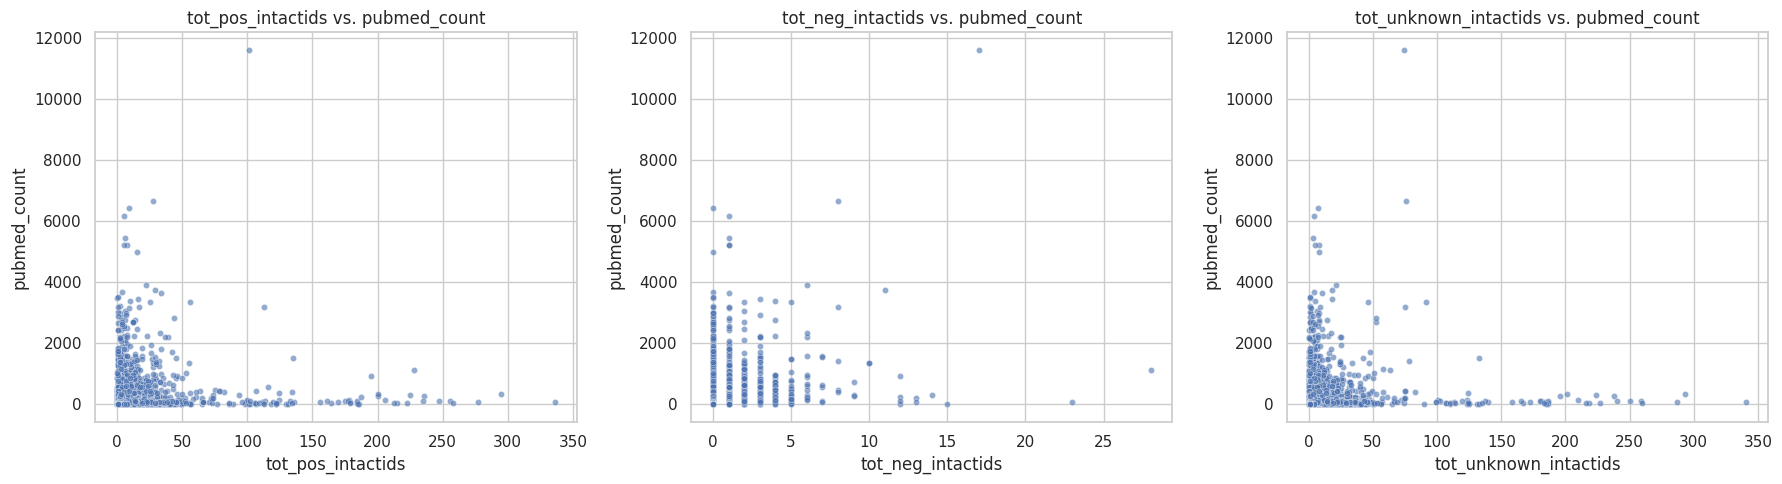

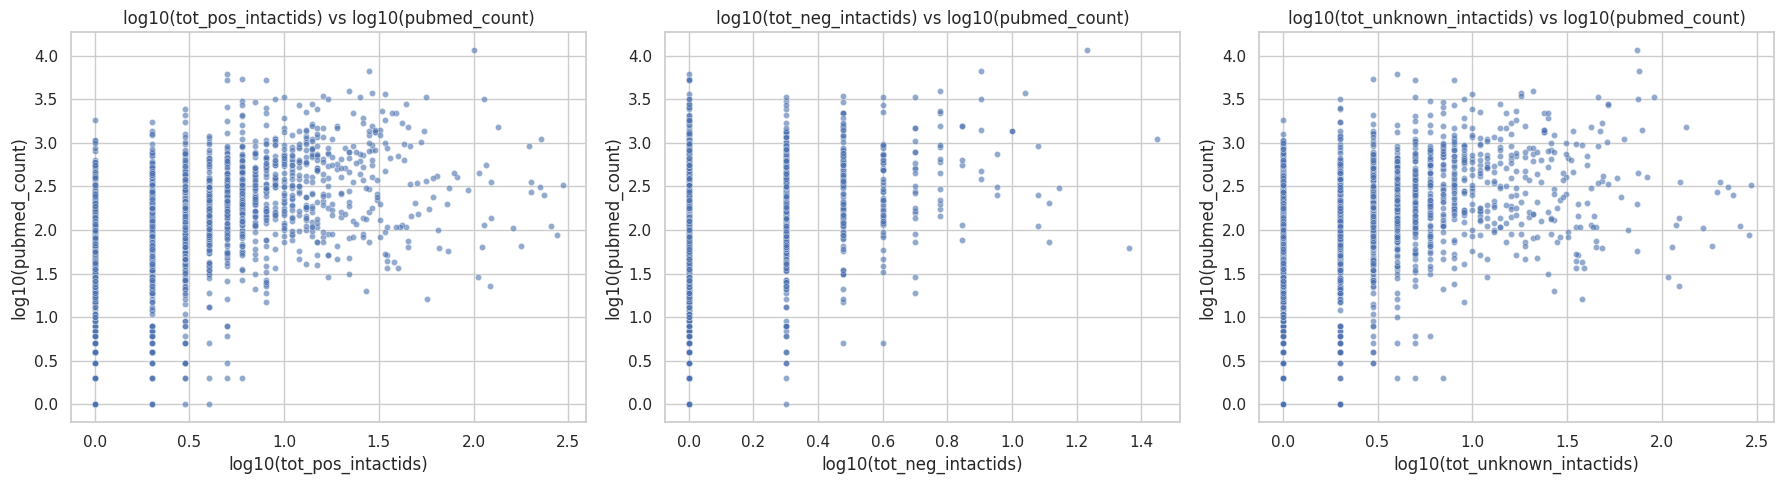


=== Correlation Summary ===
                 feature  pearson_r      pearson_p  spearman_r     spearman_p
0      tot_pos_intactids   0.119879   1.037271e-46    0.300943  1.002763e-295
1      tot_neg_intactids   0.278657  4.109928e-252    0.206300  1.319132e-136
2  tot_unknown_intactids   0.108546   1.458708e-38    0.310178   0.000000e+00


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import pandas as pd
import numpy as np

df = merged.copy()

# Columns of interest
cols = [
    "tot_pos_intactids",
    "tot_neg_intactids",
    "tot_unknown_intactids"
]

# Drop rows with missing values in these or in pubmed_count
df_clean = df[cols + ["pubmed_count"]].replace([np.inf, -np.inf], np.nan).dropna()

# ---------------------
# 1. SCATTER PLOTS
# ---------------------
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, col in zip(axes, cols):
    sns.scatterplot(
        data=df_clean,
        x=col,
        y="pubmed_count",
        ax=ax,
        s=20,
        alpha=.6
    )
    ax.set_title(f"{col} vs. pubmed_count")
    ax.set_xlabel(col)
    ax.set_ylabel("pubmed_count")

plt.tight_layout()
plt.show()

# ---------------------
# 2. OPTIONAL log–log plots (very helpful!)
# ---------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

df_log = df_clean.copy()
df_log = df_log[(df_log[cols + ["pubmed_count"]] > 0).all(axis=1)]
df_log = df_log.map(lambda x: np.log10(x))

for ax, col in zip(axes, cols):
    sns.scatterplot(
        data=df_log,
        x=col,
        y="pubmed_count",
        ax=ax,
        s=20,
        alpha=.6
    )
    ax.set_title(f"log10({col}) vs log10(pubmed_count)")
    ax.set_xlabel(f"log10({col})")
    ax.set_ylabel("log10(pubmed_count)")

plt.tight_layout()
plt.show()

# ---------------------
# 3. CORRELATION ANALYSIS
# ---------------------
results = []

for col in cols:
    pearson_r, pearson_p = pearsonr(df_clean[col], df_clean["pubmed_count"])
    spearman_r, spearman_p = spearmanr(df_clean[col], df_clean["pubmed_count"])

    results.append({
        "feature": col,
        "pearson_r": pearson_r,
        "pearson_p": pearson_p,
        "spearman_r": spearman_r,
        "spearman_p": spearman_p,
    })

results_df = pd.DataFrame(results)
print("\n=== Correlation Summary ===")
print(results_df)


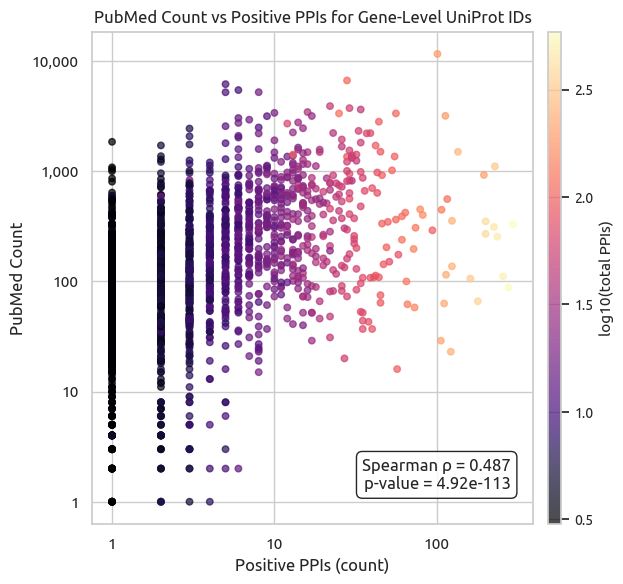

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import spearmanr
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

def make_intact_plot(df_clean, merged, xcol="tot_pos_intactids", legend_position="right"):
    """
    legend_position = 'right' or 'bottom'
    """

    # -------------------------
    # Data prep
    # -------------------------
    df_pos = df_clean[(df_clean[[xcol,"tot_neg_intactids","tot_unknown_intactids","pubmed_count"]] > 0).all(axis=1)].copy()

    df_pos["x_plot"] = df_pos[xcol]
    df_pos["y_plot"] = df_pos["pubmed_count"]
    df_pos["total_intact"] = merged.loc[df_pos.index, ["tot_pos_intactids","tot_neg_intactids","tot_unknown_intactids"]].sum(axis=1)
    df_pos["total_intact_log10"] = np.log10(df_pos["total_intact"])

    # Spearman stats
    rho, pval = spearmanr(df_pos[xcol], df_pos["pubmed_count"])

    # -------------------------
    # Figure setup
    # -------------------------
    set_font()  
    fig, ax = plt.subplots(figsize=(8, 6))

    # Main scatterplot
    points = ax.scatter(
        df_pos["x_plot"],
        df_pos["y_plot"],
        c=df_pos["total_intact_log10"],
        cmap="magma",
        s=22,
        alpha=0.70
    )

    ax.set_xscale("log")
    ax.set_yscale("log")

    formatter = FuncFormatter(lambda x, pos: f"{int(x):,}" if x >= 1 else "")
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)

    ax.set_xlabel("Positive PPIs (count)")
    ax.set_ylabel("PubMed Count")
    ax.set_title("PubMed Count vs Positive PPIs for Gene-Level UniProt IDs")

    # -------------------------
    # Add colorbar (styled + right side)
    # -------------------------
    divider = make_axes_locatable(ax)

    if legend_position == "right":
        cax = divider.append_axes("right", size="3%", pad=0.15)
        stats_xloc = 0.95
        stats_yloc = 0.10
        rect_left = 0.0
        rect_right = 0.80  # leave space for both legends
    else:  # legend_position == "bottom"
        cax = divider.append_axes("bottom", size="5%", pad=0.4)
        stats_xloc = 0.80
        stats_yloc = -0.20
        rect_left = 0.0
        rect_right = 1.0

    cb = fig.colorbar(points, cax=cax)
    cb.set_label("log10(total PPIs)", fontsize=11)
    cb.ax.tick_params(labelsize=10)

    # -------------------------
    # Spearman stats box (placed relative to figure)
    # -------------------------
    stats_text = (
        f"Spearman ρ = {rho:.3f}\n"
        f"p-value = {pval:.2e}"
    )

    fig.text(
        stats_xloc, stats_yloc,
        stats_text,
        ha="right" if legend_position=="right" else "left",
        va="center",
        fontsize=12,
        bbox=dict(
            boxstyle="round,pad=0.35",
            facecolor="white",
            edgecolor="black",
            alpha=0.85
        ),
        transform=ax.transAxes
    )

    plt.tight_layout(rect=[rect_left, 0, rect_right, 1])
    plt.savefig("pos_ppi_pubmed_v_ppis.png",dpi=300)
    plt.show()

# -------------------------
# CALL IT
# -------------------------
make_intact_plot(
    df_clean=df_clean,
    merged=merged,
    xcol="tot_pos_intactids",
    legend_position="right"      # or "bottom"
)


# AlphaFoldDB
`data_files/processed/intact/afdb_query/all_uniprots_afdb_stats.tsv`

```
uniprot_id      found   globalMetricValue  fractionPlddtVeryLow fractionPlddtLow fractionPlddtConfident  fractionPlddtVeryHigh  
A0A1D6GCY9      True    90.12   0.027   0.041   0.225   0.706   
A0A1D6FFQ4      True    79.88   0.177   0.072   0.251   0.5     
A0A1D6E1J3      True    58.91   0.493   0.082   0.399   0.026   
A0A1D6EZN4      True    84.25   0.056   0.1     0.354   0.49
```

```
sequence        sequenceStart   sequenceEnd     uniprotAccession        modelEntityId       error
MDAKPRNLGGSLPVPNVQD...       1       364     A0A1D6GCY9 AF-A0A1D6GCY9-F1
MAVATESRGSEDRASAHAN...     1       334     A0A1D6FFQ4      AF-A0A1D6FFQ4-F1
MADKKKVEVKETKVEVKTA...  1       306     A0A1D6E1J3      AF-A0A1D6E1J3-F1
MASDELAKVVEPRKKGNVK...    1       520     A0A1D6EZN4      AF-A0A1D6EZN4-F1

```

In [18]:
afdb_stats = pd.read_csv("data_files/processed/intact/afdb_query/all_uniprots_afdb_stats.tsv", sep="\t")
display(afdb_stats.head())

,uniprot_id,found,globalMetricValue,fractionPlddtVeryLow,fractionPlddtLow,fractionPlddtConfident,fractionPlddtVeryHigh,sequence,sequenceStart,sequenceEnd,uniprotAccession,modelEntityId,error
0,A0A1D6GCY9,True,90.12,0.027,0.041,0.225,0.706,MDAKPRNLGGSLPVPNVQDLAARPGDELTPPVLSRYLRDDVDGADA...,1.0,364.0,A0A1D6GCY9,AF-A0A1D6GCY9-F1,NaN
1,A0A1D6FFQ4,True,79.88,0.177,0.072,0.251,0.500,MAVATESRGSEDRASAHANQEKRWVLSDFEVGKPLGRGKFGHVYLA...,1.0,334.0,A0A1D6FFQ4,AF-A0A1D6FFQ4-F1,NaN
2,A0A1D6E1J3,True,58.91,0.493,0.082,0.399,0.026,MADKKKVEVKETKVEVKTAVYKVYVHCGQCARDIQTQFTEFQGVEE...,1.0,306.0,A0A1D6E1J3,AF-A0A1D6E1J3-F1,NaN
3,A0A1D6EZN4,True,84.25,0.056,0.100,0.354,0.490,MASDELAKVVEPRKKGNVKYASICAILASMASVILGYDIGVMSGAA...,1.0,520.0,A0A1D6EZN4,AF-A0A1D6EZN4-F1,NaN
4,A0A1D6GCY8,True,73.06,0.266,0.137,0.180,0.417,MAAPVAAYSPALRVQVKAAMDAASSFRVLASLSFPGQRASFPSIRM...,1.0,139.0,A0A1D6GCY8,AF-A0A1D6GCY8-F1,NaN


In [19]:
# make sure there are multiple sequences per uniprot ID
afdb_stats.groupby("uniprot_id")["sequence"].nunique().value_counts()

sequence
1     70776
2      7334
0      4306
3      3007
4      1412
5       704
6       382
7       207
8       131
9        66
10       46
11       30
12       30
13       19
15       11
17        8
14        7
16        7
19        4
20        3
24        2
21        2
26        2
22        2
35        1
32        1
18        1
29        1
37        1
31        1
23        1
Name: count, dtype: int64

In [20]:
afdb_stats.columns

Index(['uniprot_id', 'found', 'globalMetricValue', 'fractionPlddtVeryLow',
       'fractionPlddtLow', 'fractionPlddtConfident', 'fractionPlddtVeryHigh',
       'sequence', 'sequenceStart', 'sequenceEnd', 'uniprotAccession',
       'modelEntityId', 'error'],
      dtype='object')

In [21]:
merged["pLDDT"] = afdb_stats.groupby("uniprot_id")["globalMetricValue"].transform("mean")
def make_plddt_bin_map(x):
    if x > 90:
        return "Very high"
    elif x > 70:
        return "High"
    elif x > 50:
        return "Low"
    else:
        return "Very low"

color_map = {
    "Very high": "#0053d6",  # dark blue
    "High": "#64cbf3",       # light blue
    "Low": "#ffdb13",        # yellow
    "Very low": "#ff7d45"    # orange
} 
merged["pLDDT_bin"] = merged["pLDDT"].apply(
    lambda x: make_plddt_bin_map(x)
)
merged["pLDDT_bin_color"] = merged["pLDDT"].map(color_map)

display(merged.head())

,uniprot_id,pos_intactids,tot_pos_intactids,neg_intactids,tot_neg_intactids,unknown_intactids,tot_unknown_intactids,pubmed_count,geneids,pLDDT,pLDDT_bin,pLDDT_bin_color
0,A0A023GQA5,"intact:EBI-498791,intact:EBI-136651",2,0,0,0,0,76,49168,90.12,Very high,NaN
1,A0A023PXA5,intact:EBI-3437,1,0,0,intact:EBI-3437,1,0,0,79.88,High,NaN
2,A0A023PXP4,intact:EBI-14500,1,0,0,intact:EBI-14500,1,0,0,58.91,Low,NaN
3,A0A023PZD0,"intact:EBI-13206,intact:EBI-23329",2,0,0,"intact:EBI-13206,intact:EBI-23329",2,0,0,84.25,High,NaN
4,A0A024A2C9,"intact:EBI-1223708,intact:EBI-12684810,intact:...",3,0,0,"intact:EBI-1223708,intact:EBI-12684810,intact:...",3,0,0,73.06,High,NaN


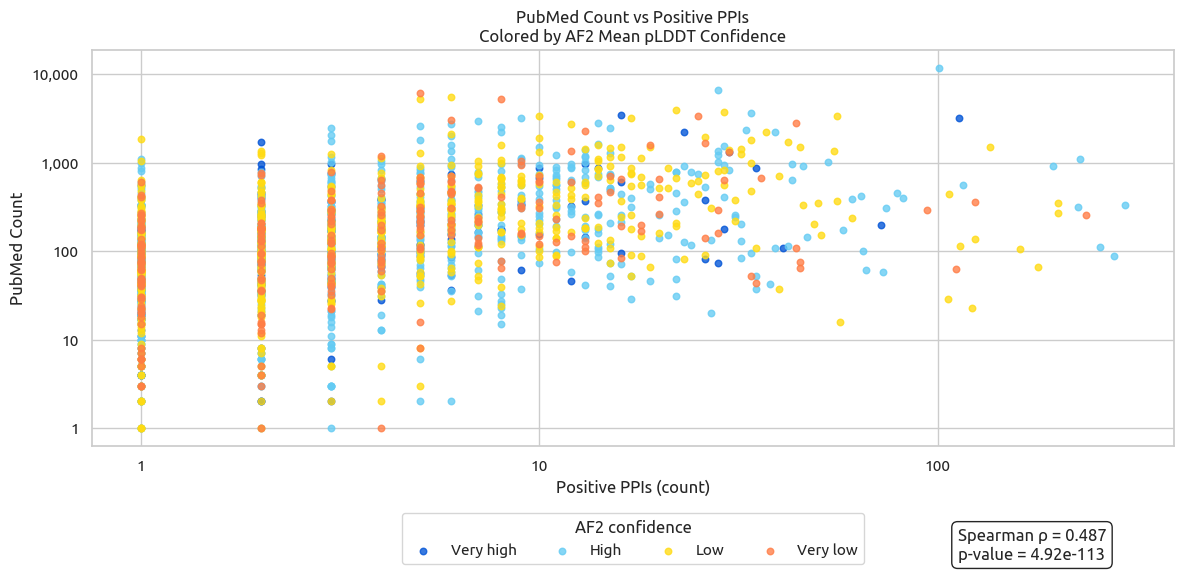

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import spearmanr
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

def make_intact_plot_by_af2(df_clean, merged, xcol="tot_pos_intactids", legend_position="right"):
    """
    Color points by average pLDDT confidence category for each UniProt ID.
    legend_position = 'right' or 'bottom'
    """

    # -------------------------
    # Data prep
    # -------------------------
    df_pos = df_clean[(df_clean[[xcol,"tot_neg_intactids","tot_unknown_intactids","pubmed_count"]] > 0).all(axis=1)].copy()

    # Extract pLDDT bin for each protein
    df_pos["pLDDT_bin"] = merged.loc[df_pos.index, "pLDDT_bin"]

    # Your AF2 bin-specific colors
    color_map = {
        "Very high": "#0053d6",  # dark blue
        "High":      "#64cbf3",  # light blue
        "Low":       "#ffdb13",  # yellow
        "Very low":  "#ff7d45"   # orange
    }

    df_pos["pLDDT_color"] = df_pos["pLDDT_bin"].map(color_map)

    # Prepare plotting columns
    df_pos["x_plot"] = df_pos[xcol]
    df_pos["y_plot"] = df_pos["pubmed_count"]

    # Spearman stats
    rho, pval = spearmanr(df_pos[xcol], df_pos["pubmed_count"])

    # -------------------------
    # Figure setup
    # -------------------------
    set_font()  
    fig, ax = plt.subplots(figsize=(12, 6))

    # Main scatterplot colored by pLDDT_bin
    for bin_label in color_map.keys():
        subset = df_pos[df_pos["pLDDT_bin"] == bin_label]
        ax.scatter(
            subset["x_plot"],
            subset["y_plot"],
            s=22,
            alpha=0.78,
            c=color_map[bin_label],
            label=bin_label
        )

    # Log scales with pretty commas
    ax.set_xscale("log")
    ax.set_yscale("log")
    formatter = FuncFormatter(lambda x, pos: f"{int(x):,}" if x >= 1 else "")
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)

    ax.set_xlabel("Positive PPIs (count)")
    ax.set_ylabel("PubMed Count")
    ax.set_title("PubMed Count vs Positive PPIs\nColored by AF2 Mean pLDDT Confidence")

    # -------------------------
    # pLDDT category legend (right side)
    # -------------------------
    if legend_position == "right":
        leg = ax.legend(
            title="AF2 confidence",
            loc="center left",
            bbox_to_anchor=(1.02, 0.5),
            frameon=True
        )
        stats_xloc = 1.22
        stats_yloc = 0.25
        rect_left = 0.0
        rect_right = 0.78
    else:
        leg = ax.legend(title="AF2 confidence", loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
        stats_xloc = 0.80
        stats_yloc = -0.25
        rect_left = 0
        rect_right = 1

    # -------------------------
    # Spearman stats box
    # -------------------------
    stats_text = (
        f"Spearman ρ = {rho:.3f}\n"
        f"p-value = {pval:.2e}"
    )

    fig.text(
        stats_xloc, stats_yloc,
        stats_text,
        ha="left",
        va="center",
        fontsize=12,
        bbox=dict(
            boxstyle="round,pad=0.35",
            facecolor="white",
            edgecolor="black",
            alpha=0.85
        ),
        transform=ax.transAxes
    )

    plt.tight_layout(rect=[rect_left, 0, rect_right, 1])
    plt.savefig("pos_ppi_pubmed_v_ppis_af2_coloring.png",dpi=300)
    plt.show()

make_intact_plot_by_af2(
    df_clean=df_clean,
    merged=merged,
    xcol="tot_pos_intactids",
    legend_position="bottom"
)


In [22]:
raise Exception

Exception: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from matplotlib.ticker import FuncFormatter

color_map = {
    "Very high": "#0053d6",  # dark blue
    "High":      "#64cbf3",  # light blue
    "Low":       "#ffdb13",  # yellow
    "Very low":  "#ff7d45"   # orange
}

def make_foldability_plot(df_clean, merged, ycol, ylabel, title, legend_position="right"):
    """
    Plot <ylabel> vs. AF2 foldability (mean pLDDT).
    - x-axis: pLDDT (0–100, linear)
    - y-axis: log10 scale
    - points colored by pLDDT confidence bin
    """

    # -------------------------
    # Data prep
    # -------------------------
    df_pos = df_clean.copy()

    # Attach foldability + bin from merged
    df_pos["pLDDT"] = merged.loc[df_pos.index, "pLDDT"]
    df_pos["pLDDT_bin"] = merged.loc[df_pos.index, "pLDDT_bin"]

    # Keep finite pLDDT and positive y
    df_pos = df_pos[
        df_pos["pLDDT"].notna() &
        (df_pos[ycol] > 0)
    ].copy()

    # Spearman correlation (raw scale; Spearman is rank-based)
    rho, pval = spearmanr(df_pos["pLDDT"], df_pos[ycol])

    set_font()
    fig, ax = plt.subplots(figsize=(8, 6))

    # Scatter per bin so we can custom-color + legend
    for bin_label, color in color_map.items():
        subset = df_pos[df_pos["pLDDT_bin"] == bin_label]
        if subset.empty:
            continue
        ax.scatter(
            subset["pLDDT"],
            subset[ycol],
            s=22,
            alpha=0.78,
            c=color,
            label=bin_label,
        )

    # Axes: x linear 0–100; y log
    raw_min = max(0, min(df_pos["pLDDT"]))
    left_bound = int(raw_min // 10) * 10

    ax.set_xlim(left_bound, 100)
    ax.set_xbound(left_bound, 100)
    ax.set_xlabel("AF2 mean pLDDT (foldability)")
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    ax.set_yscale("log")
    formatter = FuncFormatter(lambda x, pos: f"{int(x):,}" if x >= 1 else "")
    ax.yaxis.set_major_formatter(formatter)

    # x ticks: nice coarse labels 0..100
    ticks = np.arange(left_bound, 101, 10)
    ax.set_xticks(ticks)

    # -------------------------
    # Legend for pLDDT bins
    # -------------------------
    if legend_position == "right":
        leg = ax.legend(
            title="AF2 confidence",
            loc="center left",
            bbox_to_anchor=(1.02, 0.5),
            frameon=True,
        )
        stats_xloc = 1.20
        stats_yloc = 0.20
        rect_left = 0.0
        rect_right = 0.78
    else:  # bottom
        leg = ax.legend(
            title="AF2 confidence",
            loc="upper center",
            bbox_to_anchor=(0.5, -0.15),
            ncol=4,
            frameon=True,
        )
        stats_xloc = 0.05
        stats_yloc = 0.85
        rect_left = 0.0
        rect_right = 1.0

    # -------------------------
    # Spearman stats box
    # -------------------------
    stats_text = (
        f"Spearman ρ = {rho:.3f}\n"
        f"p-value = {pval:.2e}"
    )

    fig.text(
        stats_xloc,
        stats_yloc,
        stats_text,
        ha="left",
        va="center",
        fontsize=12,
        bbox=dict(
            boxstyle="round,pad=0.35",
            facecolor="white",
            edgecolor="black",
            alpha=0.85,
        ),
        transform=ax.transAxes,
    )

    plt.tight_layout(rect=[rect_left, 0, rect_right, 1])
    plt.show()


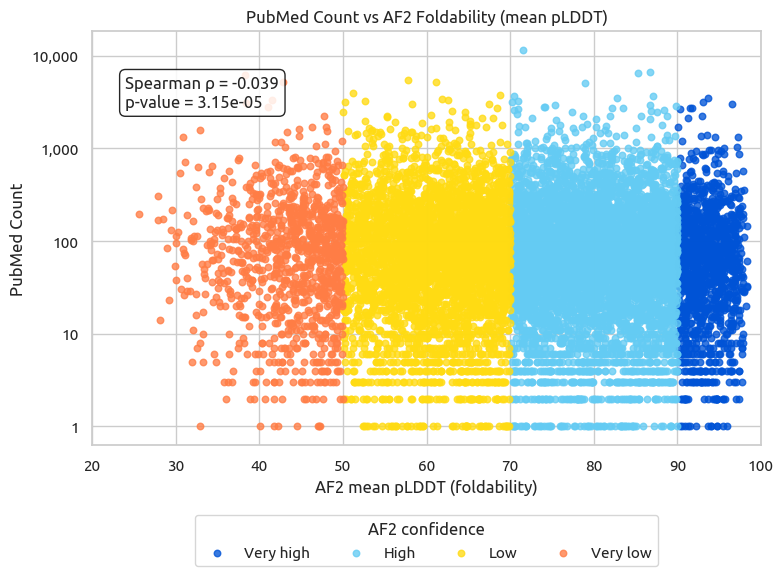

In [ ]:
make_foldability_plot(
    df_clean=df_clean,
    merged=merged,
    ycol="pubmed_count",
    ylabel="PubMed Count",
    title="PubMed Count vs AF2 Foldability (mean pLDDT)",
    legend_position="bottom",
)


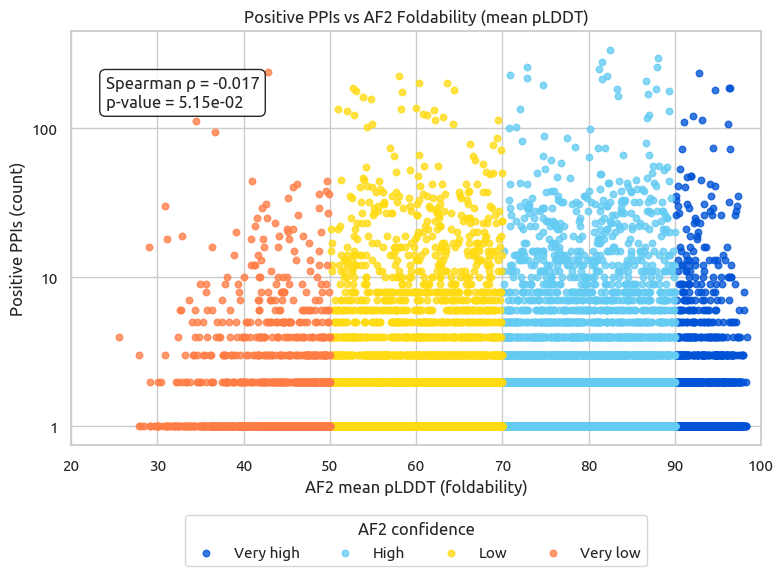

In [ ]:
make_foldability_plot(
    df_clean=df_clean,
    merged=merged,
    ycol="tot_pos_intactids",
    ylabel="Positive PPIs (count)",
    title="Positive PPIs vs AF2 Foldability (mean pLDDT)",
    legend_position="bottom",
)


In [ ]:
# plot positive PPIs versus foldability 

In [ ]:
display(pos[[
    "all_intact_A_sorted","uniprot_A","gene_symbol_1","aa_1",
    "all_intact_B_sorted","uniprot_B","gene_symbol_2","aa_2",
]].head())

# group by aa_1 and count aa_2. That seems like the best way to do it. 


,all_intact_A_sorted,uniprot_A,gene_symbol_1,aa_1,all_intact_B_sorted,uniprot_B,gene_symbol_2,aa_2
0,intact:EBI-13206,uniprotkb:P80667-0,PEX13,MSSTAVPRPKPWETSASLEEPQRNAQSLSAMMTSNQQDSRPTEESN...,intact:EBI-7322830,uniprotkb:A0A023PZD0-0,NaN,MTIVHFVGSLFFFFFFSYIFFYNDHGLYTWGCNFAMESPSPTSSPS...
1,intact:EBI-7144545,uniprotkb:Q8VDF2-0,Uhrf1,MWIQVRTMDGKETHTVNSLSRLTKVQELRKKIEEVFHVEPQLQRLF...,intact:EBI-2527113,uniprotkb:C0HKE2-0,H2ac4,MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYSERVGA...
2,intact:EBI-3719,uniprotkb:P38041-0,BOI1,MSLEGNTLGKGAKSFPLYIAVNQYSKRMEDELNMKPGDKIKVITDD...,intact:EBI-7309141,uniprotkb:C8Z569-0,NaN,MKTSRSTTTDQVCCPWPTPVQTPTVLNSSSPPFHAHGWTVSMLSLV...
3,intact:EBI-740492,uniprotkb:Q9UKI8-0,TLK1,MSVQSSSGSLEGPPSWSQLSTSPTPGSAAAARSLLNHTPPSGRPRE...,intact:EBI-745000,uniprotkb:O00161-0,SNAP23,MDNLSSEEIQQRAHQITDESLESTRRILGLAIESQDAGIKTITMLD...
4,intact:EBI-963034,uniprotkb:Q15418-0,RPS6KA1,MPLAQLKEPWPLMELVPLDPENGQTSGEEAGLQPSKDEGVLKEISI...,intact:EBI-6255306,uniprotkb:O00418-0,EEF2K,MADEDLIFRLEGVDGGQSPRAGHDGDSDGDSDDEEGYFICPITDDP...


In [ ]:
# merge this information on a per-sequence basis 
# get total unknownitive, unknown, and negative PPIs for each
aa_1_to_aa_2_pos = (
    pos
    .dropna(subset=["aa_1"])   # optional, in case To has NaNs
    .groupby("aa_1")["aa_2"]
    .apply(lambda x: ",".join(list(x)))
)
aa_2_to_aa_1_pos = (
    pos
    .dropna(subset=["aa_2"])   # optional, in case To has NaNs
    .groupby("aa_2")["aa_1"]
    .apply(lambda x: ",".join(list(x)))
)
aa_to_aa_pos = pd.concat([aa_1_to_aa_2_pos,aa_2_to_aa_1_pos]).reset_index().rename(columns={"index":"aa_query",0:"aa_partners"})
aa_to_aa_pos = (
    aa_to_aa_pos
    .groupby("aa_query")["aa_partners"]
    .apply(lambda x: ",".join(list(x)))
)
aa_to_aa_pos = aa_to_aa_pos.reset_index()
aa_to_aa_pos["aa_partners"] = aa_to_aa_pos["aa_partners"].apply(lambda x: ",".join(list(set(x.split(",")))))
aa_to_aa_pos["tot_aa_partners"] = aa_to_aa_pos["aa_partners"].apply(lambda x: len(x.split(",")) if pd.notna(x) else 0)
aa_to_aa_pos = aa_to_aa_pos.drop(columns=["aa_partners"]).rename(columns={"aa_query":"sequence"})
display(aa_to_aa_pos)

,sequence,tot_aa_partners
0,AAAAARPAGGSARRWGRPGRCGLLAAGPKRVRSEPGGRLPERSLGP...,1
1,AADAPAQLDPAGEKLYRSACVVCHASGVANAPKLGDKQAWAPFLAQ...,1
2,AAF,1
3,AANKRKNQNRNKSSSHQDSSRMSSVGDYNTSEQKQACKKHELYVSF...,1
4,AAPF,1
...,...,...
18898,YSPTSPSYSPTSPS,3
18899,YSPTSPSYSPTSPSYSPTSPSYSPTSPS,5
18900,YTPNDPYFSSRQYGPQKIQAPQAWDIAEGSGAKIAIVDTGVQSNHP...,1
18901,YVADAP,1


In [ ]:
neg.loc[
    (neg["aa_2"].isna()) | 
    (neg["aa_1"].isna()) 
][["aa_1","aa_2","seq_sort"]]

,aa_1,aa_2,seq_sort


In [ ]:
# merge this information on a per-sequence basis 
# get total unknownitive, unknown, and negative PPIs for each
aa_1_to_aa_2_neg = (
    neg
    .dropna(subset=["aa_1"])   # optional, in case To has NaNs
    .groupby("aa_1")["aa_2"]
    .apply(lambda x: ",".join(list(x)))
)
aa_2_to_aa_1_neg = (
    neg
    .dropna(subset=["aa_2"])   # optional, in case To has NaNs
    .groupby("aa_2")["aa_1"]
    .apply(lambda x: ",".join(list(x)))
)
aa_to_aa_neg = pd.concat([aa_1_to_aa_2_neg,aa_2_to_aa_1_neg]).reset_index().rename(columns={"index":"aa_query",0:"aa_partners"})
aa_to_aa_neg = (
    aa_to_aa_neg
    .groupby("aa_query")["aa_partners"]
    .apply(lambda x: ",".join(list(x)))
)
aa_to_aa_neg = aa_to_aa_neg.reset_index()
aa_to_aa_neg["aa_partners"] = aa_to_aa_neg["aa_partners"].apply(lambda x: ",".join(list(set(x.split(",")))))
aa_to_aa_neg["tot_aa_partners"] = aa_to_aa_neg["aa_partners"].apply(lambda x: len(x.split(",")) if pd.notna(x) else 0)
aa_to_aa_neg = aa_to_aa_neg.drop(columns=["aa_partners"]).rename(columns={"aa_query":"sequence"})
display(aa_to_aa_neg)

,sequence,tot_aa_partners
0,AADNFAEEFAVAA,1
1,AAKIYTGLRAQGNYNLPKHCDNNEVLKALCSEAGWVVEEDGTTYRK...,1
2,AAMSDVKCTSVVLLSVLQQLRVESSSKLWAQCVQLHNDILLAKDTT...,1
3,AANRALEMKVKELSVIQELTKELGSCLDLDRTAGIITRHLQELLNC...,1
4,AAQKRPSQRSKYLASASTMDHARHGFLPRHRDTGILDSLGRFFGSD...,4
...,...,...
6365,YMDIESTEIEDMTFEPENQMFTYPCPCGDRFQIYLDDMFEGEKVAV...,1
6366,YNDNFAEEFAVAA,1
6367,YQVRNSSGLYHVTNDCPNSSVVYEAADAILHTPGCVPCVREGNASR...,9
6368,YVDQPGDMAFKGAGSRDSDSISKGSSVARQSVEGTDAAWGKDDMFE...,1


In [ ]:
# merge this information on a per-sequence basis 
# get total unknownitive, unknown, and unknownative PPIs for each
aa_1_to_aa_2_unknown = (
    unknown
    .dropna(subset=["aa_1"])   # optional, in case To has NaNs
    .groupby("aa_1")["aa_2"]
    .apply(lambda x: ",".join(list(x)))
)
aa_2_to_aa_1_unknown = (
    unknown
    .dropna(subset=["aa_2"])   # optional, in case To has NaNs
    .groupby("aa_2")["aa_1"]
    .apply(lambda x: ",".join(list(x)))
)
aa_to_aa_unknown = pd.concat([aa_1_to_aa_2_unknown,aa_2_to_aa_1_unknown]).reset_index().rename(columns={"index":"aa_query",0:"aa_partners"})
aa_to_aa_unknown = (
    aa_to_aa_unknown
    .groupby("aa_query")["aa_partners"]
    .apply(lambda x: ",".join(list(x)))
)
aa_to_aa_unknown = aa_to_aa_unknown.reset_index()
aa_to_aa_unknown["aa_partners"] = aa_to_aa_unknown["aa_partners"].apply(lambda x: ",".join(list(set(x.split(",")))))
aa_to_aa_unknown["tot_aa_partners"] = aa_to_aa_unknown["aa_partners"].apply(lambda x: len(x.split(",")) if pd.notna(x) else 0)
aa_to_aa_unknown = aa_to_aa_unknown.drop(columns=["aa_partners"]).rename(columns={"aa_query":"sequence"})
display(aa_to_aa_unknown)

TypeError: sequence item 0: expected str instance, float found

In [ ]:
color_map = {
    "Very high": "#0053d6",  # dark blue
    "High": "#64cbf3",       # light blue
    "Low": "#ffdb13",        # yellow
    "Very low": "#ff7d45"    # orange
} 
afdb_stats["pLDDT"] = afdb_stats["globalMetricValue"]
afdb_stats["pLDDT_bin"] = afdb_stats["pLDDT"].apply(
    lambda x: make_plddt_bin_map(x)
)
afdb_stats["pLDDT_bin_color"] = afdb_stats["pLDDT"].map(color_map)

In [ ]:
afdb_stats_merge_pos = afdb_stats.merge(aa_to_aa_pos, on="sequence", how="inner")
test1 = len(afdb_stats_merge_pos['sequence'].unique())
print(f"Total sequences that have AFDB entries: {test1}/{len(aa_to_aa_pos)} ({test1/len(aa_to_aa_pos)*100:.2f}%)")
afdb_stats_merge_pos.head()

Total sequences that have AFDB entries: 86403/110501 (78.19%)


,uniprot_id,found,globalMetricValue,fractionPlddtVeryLow,fractionPlddtLow,fractionPlddtConfident,fractionPlddtVeryHigh,sequence,sequenceStart,sequenceEnd,uniprotAccession,modelEntityId,error,pLDDT,pLDDT_bin,pLDDT_bin_color,tot_aa_partners
0,A0A1D6GCY9,True,90.12,0.027,0.041,0.225,0.706,MDAKPRNLGGSLPVPNVQDLAARPGDELTPPVLSRYLRDDVDGADA...,1.0,364.0,A0A1D6GCY9,AF-A0A1D6GCY9-F1,NaN,90.12,Very high,NaN,1
1,A0A1D6FFQ4,True,79.88,0.177,0.072,0.251,0.500,MAVATESRGSEDRASAHANQEKRWVLSDFEVGKPLGRGKFGHVYLA...,1.0,334.0,A0A1D6FFQ4,AF-A0A1D6FFQ4-F1,NaN,79.88,High,NaN,1
2,A0A1D6E1J3,True,58.91,0.493,0.082,0.399,0.026,MADKKKVEVKETKVEVKTAVYKVYVHCGQCARDIQTQFTEFQGVEE...,1.0,306.0,A0A1D6E1J3,AF-A0A1D6E1J3-F1,NaN,58.91,Low,NaN,3
3,A0A1D6EZN4,True,84.25,0.056,0.100,0.354,0.490,MASDELAKVVEPRKKGNVKYASICAILASMASVILGYDIGVMSGAA...,1.0,520.0,A0A1D6EZN4,AF-A0A1D6EZN4-F1,NaN,84.25,High,NaN,1
4,A0A1D6GCY8,True,73.06,0.266,0.137,0.180,0.417,MAAPVAAYSPALRVQVKAAMDAASSFRVLASLSFPGQRASFPSIRM...,1.0,139.0,A0A1D6GCY8,AF-A0A1D6GCY8-F1,NaN,73.06,High,NaN,21


In [ ]:
afdb_stats_merge_neg = afdb_stats.merge(aa_to_aa_neg, on="sequence", how="inner")
test1 = len(afdb_stats_merge_neg['sequence'].unique())
print(f"Total sequences that have AFDB entries: {test1}/{len(aa_to_aa_neg)} ({test1/len(aa_to_aa_neg)*100:.2f}%)")
afdb_stats_merge_neg.head()

Total sequences that have AFDB entries: 4588/12915 (35.52%)


,uniprot_id,found,globalMetricValue,fractionPlddtVeryLow,fractionPlddtLow,fractionPlddtConfident,fractionPlddtVeryHigh,sequence,sequenceStart,sequenceEnd,uniprotAccession,modelEntityId,error,pLDDT,pLDDT_bin,pLDDT_bin_color,tot_aa_partners
0,A0A0H2UVV3,True,77.81,0.180,0.063,0.343,0.413,MIQIGKLFAGRYRILKSIGRGGMADVYLANDLILDNEDVAIKVLRT...,1.0,632.0,A0A0H2UVV3,AF-A0A0H2UVV3-F1,NaN,77.81,High,NaN,2
1,A0A0F6B1Q8,True,88.00,0.010,0.054,0.417,0.520,MPLSVGQGYFTSSISSEKFNAIKESARLPELSLWEKIKAYFFTTHH...,1.0,408.0,A0A0F6B1Q8,AF-A0A0F6B1Q8-F1,NaN,88.00,High,NaN,4
2,A0A0F6B941,True,55.28,0.369,0.502,0.129,0.000,MASENMTPQEYIGHHLNNLQLDLRTFSLVDPQNPPATFWTLNIDSM...,1.0,271.0,A0A0F6B941,AF-A0A0F6B941-F1,NaN,55.28,Low,NaN,1
3,A0A0D6GID3,True,83.25,0.077,0.048,0.432,0.443,MPITIGNGFLKSEILTNSPRNTKEAWWKVLWEKIKDFFFSTGKAKA...,1.0,336.0,A0A0D6GID3,AF-A0A0D6GID3-F1,NaN,83.25,High,NaN,2
4,A0A1B0GVM0,True,47.72,0.681,0.142,0.018,0.159,MLSGASSQARGSNPTCPRQDGYSSLLEPGTEAPIKEAHRQDLRSHM...,1.0,812.0,A0A1B0GVM0,AF-A0A1B0GVM0-F1,NaN,47.72,Very low,NaN,1


In [ ]:
afdb_stats_merge_unknown = afdb_stats.merge(aa_to_aa_unknown, on="sequence", how="inner")
test1 = len(afdb_stats_merge_unknown['sequence'].unique())
print(f"Total sequences that have AFDB entries: {test1}/{len(aa_to_aa_unknown)} ({test1/len(aa_to_aa_unknown)*100:.2f}%)")
afdb_stats_merge_unknown.head()

Total sequences that have AFDB entries: 3975/5488 (72.43%)


,uniprot_id,found,globalMetricValue,fractionPlddtVeryLow,fractionPlddtLow,fractionPlddtConfident,fractionPlddtVeryHigh,sequence,sequenceStart,sequenceEnd,uniprotAccession,modelEntityId,error,pLDDT,pLDDT_bin,pLDDT_bin_color,tot_aa_partners
0,A0A0F6AW51,True,90.88,0.100,0.012,0.037,0.851,MPINRPNLNLNIPPLNIVAAYDGAEIPSTNKHLKNNFNSLHNQMRK...,1.0,241.0,A0A0F6AW51,AF-A0A0F6AW51-F1,NaN,90.88,Very high,NaN,2
1,A0A0F6B1Q8,True,88.00,0.010,0.054,0.417,0.520,MPLSVGQGYFTSSISSEKFNAIKESARLPELSLWEKIKAYFFTTHH...,1.0,408.0,A0A0F6B1Q8,AF-A0A0F6B1Q8-F1,NaN,88.00,High,NaN,1
2,A0A0H3NF38,True,79.44,0.060,0.206,0.401,0.334,MPFHIGSGCLPATISNRRIYRIAWSDTPPEMSSWEKMKEFFCSTHQ...,1.0,788.0,A0A0H3NF38,AF-A0A0H3NF38-F1,NaN,79.44,High,NaN,2
3,A0A0H3K9R3,True,81.81,0.161,0.143,0.050,0.646,MQFMGTASRMASTQRAKPMEMPRISRDTARMLVNYLTYQAVCVIRD...,1.0,161.0,A0A0H3K9R3,AF-A0A0H3K9R3-F1,NaN,81.81,High,NaN,1
4,A0A0H3K900,True,85.94,0.009,0.063,0.480,0.448,MMKFHHRLMLLISSILIISFVTLGIIIHASITYVLSEKHEQALATD...,1.0,554.0,A0A0H3K900,AF-A0A0H3K900-F1,NaN,85.94,High,NaN,1


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from matplotlib.ticker import FuncFormatter

# Reuse your AF2 bin color map (just to be explicit & consistent)
plddt_color_map = {
    "Very high": "#0053d6",  # dark blue
    "High":      "#64cbf3",  # light blue
    "Low":       "#ffdb13",  # yellow
    "Very low":  "#ff7d45",  # orange
}

def make_partner_vs_plddt_plot(
    df,
    ppi_type="Positive",        # "Positive", "Negative", or "Unknown"
    legend_position="right"
):
    """
    Plot Total Partners (by sequence) vs pLDDT for a given AFDB stats dataframe.

    Expected columns in df:
      - 'pLDDT'           : mean AF2 pLDDT per UniProt
      - 'pLDDT_bin'       : categorical bin label (Very high / High / Low / Very low)
      - 'tot_aa_partners' : integer count of partners (by sequence)
    """

    # -------------------------
    # Data prep
    # -------------------------
    df_plot = df.copy()

    # Ensure required columns exist
    required = ["pLDDT", "pLDDT_bin", "tot_aa_partners"]
    missing = [c for c in required if c not in df_plot.columns]
    if missing:
        raise ValueError(f"DataFrame is missing required columns: {missing}")

    # Filter to valid points: finite pLDDT and positive partner count
    df_plot = df_plot[
        df_plot["pLDDT"].notna() &
        (df_plot["tot_aa_partners"] > 0)
    ].copy()

    if df_plot.empty:
        raise ValueError("No valid rows after filtering for pLDDT and tot_aa_partners > 0.")

    # Spearman correlation (raw scales)
    rho, pval = spearmanr(df_plot["pLDDT"], df_plot["tot_aa_partners"])

    # Nice dynamic x-axis bounds based on data (rounded to tens)
    raw_min = df_plot["pLDDT"].min()
    raw_max = df_plot["pLDDT"].max()
    left_bound  = max(0, (int(raw_min) // 10) * 10)
    right_bound = min(100, int(np.ceil(raw_max / 10.0) * 10))

    # -------------------------
    # Figure setup
    # -------------------------
    set_font()
    fig, ax = plt.subplots(figsize=(8, 6))

    # Scatter by AF2 bin so we can control color + legend
    for bin_label in plddt_color_map.keys():
        subset = df_plot[df_plot["pLDDT_bin"] == bin_label]
        if subset.empty:
            continue
        ax.scatter(
            subset["pLDDT"],
            subset["tot_aa_partners"],
            s=22,
            alpha=0.78,
            c=plddt_color_map[bin_label],
            label=bin_label,
        )

    # Axes: x = pLDDT [0–100], y = log-counts
    ax.set_xlim(left_bound, right_bound)
    ax.set_xlabel("AlphaFold2 pLDDT (foldability)")
    ax.set_ylabel("Total Partners (by sequence)")

    # Log y-scale with pretty formatted ticks
    ax.set_yscale("log")
    formatter = FuncFormatter(lambda x, pos: f"{int(x):,}" if x >= 1 else "")
    ax.yaxis.set_major_formatter(formatter)

    # Choose x ticks in tens
    ax.set_xticks(list(range(left_bound, right_bound + 1, 10)))

    # Title based on PPI type
    ax.set_title(f"Total Partners (by sequence) vs Foldability\n{ppi_type} PPIs")

    # -------------------------
    # Legend position logic
    # -------------------------
    if legend_position == "right":
        leg = ax.legend(
            title="AF2 confidence",
            loc="center left",
            bbox_to_anchor=(1.02, 0.5),
            frameon=True,
        )
        stats_xloc = 1.20
        stats_yloc = 0.20
        rect_left = 0.0
        rect_right = 0.78
    else:  # "bottom"
        leg = ax.legend(
            title="AF2 confidence",
            loc="upper center",
            bbox_to_anchor=(0.5, -0.15),
            ncol=4,
            frameon=True,
        )
        stats_xloc = 0.05
        stats_yloc = 0.85
        rect_left = 0.0
        rect_right = 1.0

    # -------------------------
    # Spearman stats box
    # -------------------------
    stats_text = (
        f"Spearman ρ = {rho:.3f}\n"
        f"p-value = {pval:.2e}"
    )

    fig.text(
        stats_xloc,
        stats_yloc,
        stats_text,
        ha="left",
        va="center",
        fontsize=12,
        bbox=dict(
            boxstyle="round,pad=0.35",
            facecolor="white",
            edgecolor="black",
            alpha=0.85,
        ),
        transform=ax.transAxes,
    )

    plt.tight_layout(rect=[rect_left, 0, rect_right, 1])
    plt.show()


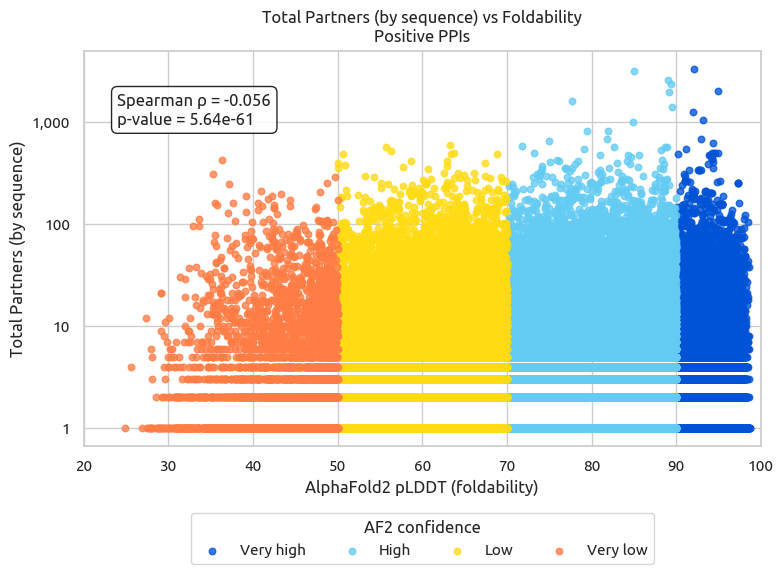

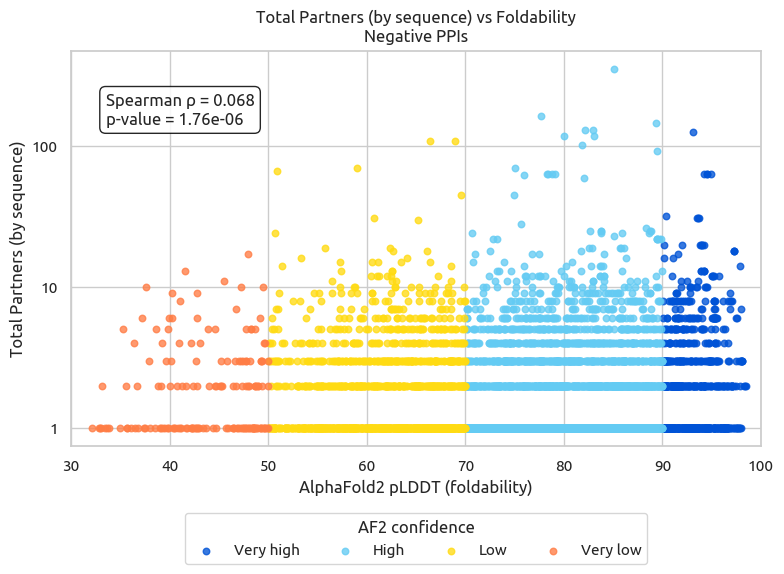

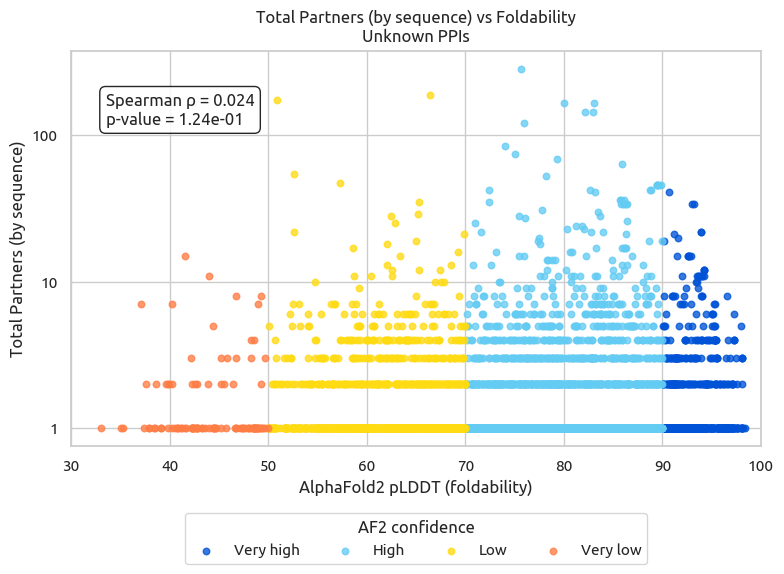

In [ ]:
# Positive PPIs
make_partner_vs_plddt_plot(
    df=afdb_stats_merge_pos,
    ppi_type="Positive",
    legend_position="bottom",
)

# Negative PPIs
make_partner_vs_plddt_plot(
    df=afdb_stats_merge_neg,
    ppi_type="Negative",
    legend_position="bottom",
)

# Unknown PPIs
make_partner_vs_plddt_plot(
    df=afdb_stats_merge_unknown,
    ppi_type="Unknown",
    legend_position="bottom",
)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Patch
import matplotlib

# AF2 bin color map
plddt_color_map = {
    "Very high": "#0053d6",  # dark blue
    "High":      "#64cbf3",  # light blue
    "Low":       "#ffdb13",  # yellow
    "Very low":  "#ff7d45",  # orange
}

# AF2 bin intervals in pLDDT space (matching your make_plddt_bin_map logic)
PLDDT_INTERVALS = [
    ("Very low",   0, 50),
    ("Low",       50, 70),
    ("High",      70, 90),
    ("Very high", 90, 100),
]


def make_partner_vs_plddt_plot_binned(
    df,
    ppi_type="Positive",        # "Positive", "Negative", or "Unknown"
    legend_position="right"
):
    """
    Alternate visualization:
      - Background colored by AF2 pLDDT bins.
      - Points plotted in neutral grey.
      - Bin medians overlaid as colored markers.
      - Legend includes counts per bin.
    """

    # -------------------------
    # Data prep
    # -------------------------
    df_plot = df.copy()

    required = ["pLDDT", "pLDDT_bin", "tot_aa_partners"]
    missing = [c for c in required if c not in df_plot.columns]
    if missing:
        raise ValueError(f"DataFrame is missing required columns: {missing}")

    df_plot = df_plot[
        df_plot["pLDDT"].notna() &
        (df_plot["tot_aa_partners"] > 0)
    ].copy()

    if df_plot.empty:
        raise ValueError("No valid rows after filtering for pLDDT and tot_aa_partners > 0.")

    # Spearman correlation on raw values
    rho, pval = spearmanr(df_plot["pLDDT"], df_plot["tot_aa_partners"])

    # Dynamic x-bounds
    raw_min = df_plot["pLDDT"].min()
    raw_max = df_plot["pLDDT"].max()
    left_bound  = max(0, (int(raw_min) // 10) * 10)
    right_bound = min(100, int(np.ceil(raw_max / 10.0) * 10))

    # Counts per bin for legend labels
    bin_counts = df_plot["pLDDT_bin"].value_counts().to_dict()

    # -------------------------
    # Figure setup
    # -------------------------
    set_font()
    fig, ax = plt.subplots(figsize=(8, 6))

    # 1) Background colored by AF2 intervals
    for name, start, end in PLDDT_INTERVALS:
        ax.axvspan(
            start, end,
            facecolor=plddt_color_map[name],
            alpha=0.15,
            zorder=0
        )

    # 2) Scatter points in neutral grey on top
    ax.scatter(
        df_plot["pLDDT"],
        df_plot["tot_aa_partners"],
        s=10,
        alpha=0.35,
        color="#333333",
        edgecolors="none",
        zorder=1,
    )

    # 3) Overlay medians per AF2 bin (one big dot per bin)
    if False:
        for name, start, end in PLDDT_INTERVALS:
            sub = df_plot[(df_plot["pLDDT"] >= start) & (df_plot["pLDDT"] < end)]
            if sub.empty:
                continue
            x_med = sub["pLDDT"].median()
            y_med = sub["tot_aa_partners"].median()
            ax.scatter(
                x_med,
                y_med,
                s=90,
                marker="o",
                edgecolor="black",
                linewidth=1.0,
                facecolor=plddt_color_map[name],
                zorder=3,
            )

    # Axes
    ax.set_xlim(left_bound, right_bound)
    ax.set_xlabel("AlphaFold2 pLDDT (foldability)")
    ax.set_ylabel("Total Partners (by sequence)")

    ax.set_yscale("log")
    formatter = FuncFormatter(lambda x, pos: f"{int(x):,}" if x >= 1 else "")
    ax.yaxis.set_major_formatter(formatter)

    ax.set_xticks(list(range(left_bound, right_bound + 1, 10)))

    ax.set_title(f"Total Partners (by sequence) vs Foldability\n{ppi_type} PPIs")

    # -------------------------
    # Legend with counts per AF2 bin
    # -------------------------
    handles = []
    # Keep a nice order: Very high → High → Low → Very low
    legend_order = ["Very low", "Low", "High", "Very high"]

    for name in legend_order:
        count = bin_counts.get(name, 0)
        label = f"{name} ({count:,})"
        patch = Patch(
            facecolor=plddt_color_map[name],
            edgecolor="none",
            label=label,
        )
        handles.append(patch)
    
    # Median marker legend entry
    median_legend = matplotlib.lines.Line2D(
        [], [], 
        marker='o', 
        color='black',
        markersize=8,
        markerfacecolor='white',
        markeredgewidth=1.5,
        label='Median per bin'
    )


    if legend_position == "right":
        ax.legend(
            handles=handles,# + [median_legend],
            title="AF2 confidence",
            loc="center left",
            bbox_to_anchor=(1.02, 0.5),
            frameon=True,
        )
        stats_xloc = 1.20
        stats_yloc = 0.20
        rect_left = 0.0
        rect_right = 0.78
    else:  # "bottom"
        ax.legend(
            handles=handles,# + [median_legend],
            title="AF2 confidence",
            loc="upper center",
            bbox_to_anchor=(0.5, -0.15),
            ncol=4,
            frameon=True,
        )
        stats_xloc = 0.05
        stats_yloc = 0.85
        rect_left = 0.0
        rect_right = 1.0

    # -------------------------
    # Spearman stats box
    # -------------------------
    stats_text = (
        f"Spearman ρ = {rho:.3f}\n"
        f"p-value = {pval:.2e}"
    )

    fig.text(
        stats_xloc,
        stats_yloc,
        stats_text,
        ha="left",
        va="center",
        fontsize=12,
        bbox=dict(
            boxstyle="round,pad=0.35",
            facecolor="white",
            edgecolor="black",
            alpha=0.85,
        ),
        transform=ax.transAxes,
    )

    from matplotlib.lines import Line2D

    plt.tight_layout(rect=[rect_left, 0, rect_right, 1])
    plt.show()


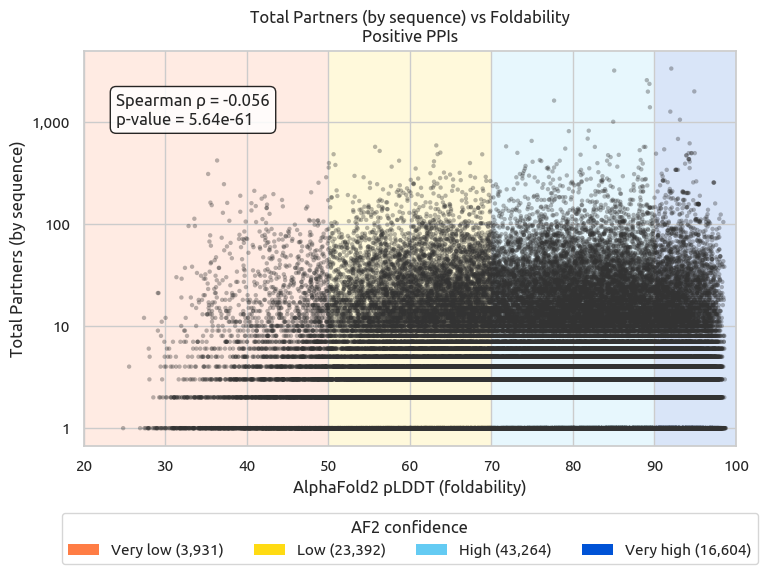

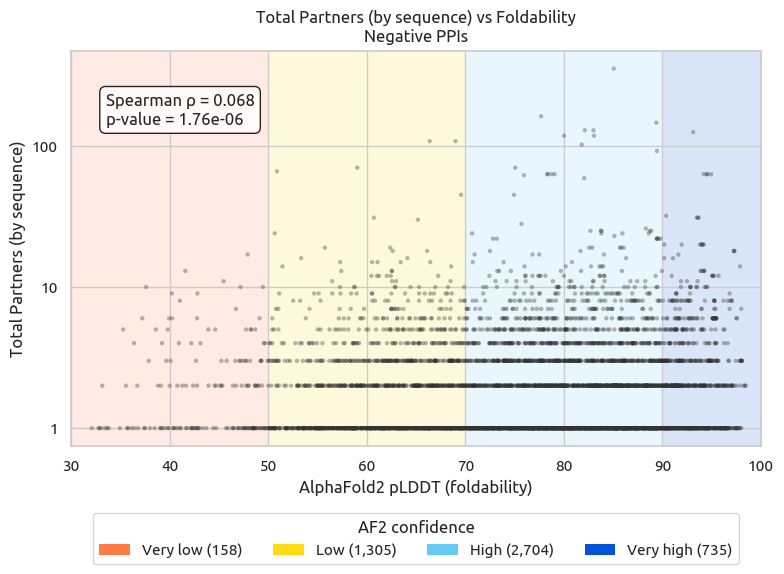

In [ ]:
make_partner_vs_plddt_plot_binned(
    df=afdb_stats_merge_pos,
    ppi_type="Positive",
    legend_position="bottom",   # or "right"
)

make_partner_vs_plddt_plot_binned(
    df=afdb_stats_merge_neg,
    ppi_type="Negative",
    legend_position="bottom",   # or "right"
)



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter

plddt_color_map = {
    "Very low":  "#ff7d45",
    "Low":       "#ffdb13",
    "High":      "#64cbf3",
    "Very high": "#0053d6",
}

def make_partner_distribution_plot(df, ppi_type="Positive"):
    """
    Companion figure: distribution of Total Partners by pLDDT bin.
    """

    df_plot = df.copy()
    df_plot = df_plot[
        df_plot["pLDDT"].notna() &
        df_plot["tot_aa_partners"].notna() &
        (df_plot["tot_aa_partners"] > 0)
    ].copy()

    set_font()
    fig, ax = plt.subplots(figsize=(9, 5))

    # Ordered bins for sensible left→right progression
    order = ["Very low", "Low", "High", "Very high"]

    # Violin plot (distribution)
    sns.violinplot(
        data=df_plot, 
        x="pLDDT_bin", 
        y="tot_aa_partners",
        order=order,
        palette=plddt_color_map,
        cut=0,
        scale="width",
        ax=ax
    )

    # Boxplot overlay (medians + quartiles)
    if False:
        sns.boxplot(
            data=df_plot,
            x="pLDDT_bin",
            y="tot_aa_partners",
            order=order,
            showcaps=True,
            boxprops={'edgecolor': 'black', 'facecolor': 'white'},
            showfliers=False,
            whiskerprops={'color': 'black'},
            medianprops={'color': 'black', 'linewidth': 2},
            ax=ax
        )

    # Log-scale y-axis with pretty formatting
    ax.set_yscale("log")
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x):,}"))

    ax.set_xlabel("AF2 pLDDT Bin (foldability)")
    ax.set_ylabel("Total Partners (by sequence)")
    ax.set_title(f"Distribution of Total Partners by pLDDT Bin\n{ppi_type} PPIs")

    plt.tight_layout()
    plt.show()


/tmp/ipykernel_317837/593959527.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_317837/593959527.py:32: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


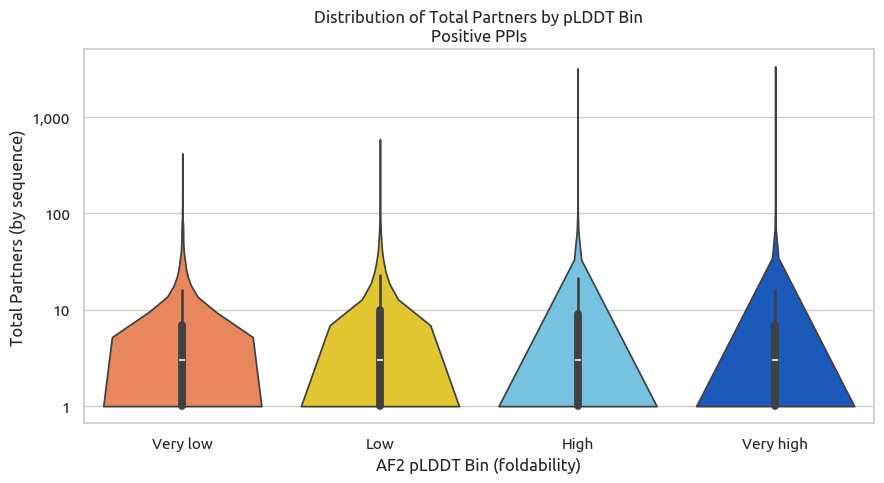

/tmp/ipykernel_317837/593959527.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_317837/593959527.py:32: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


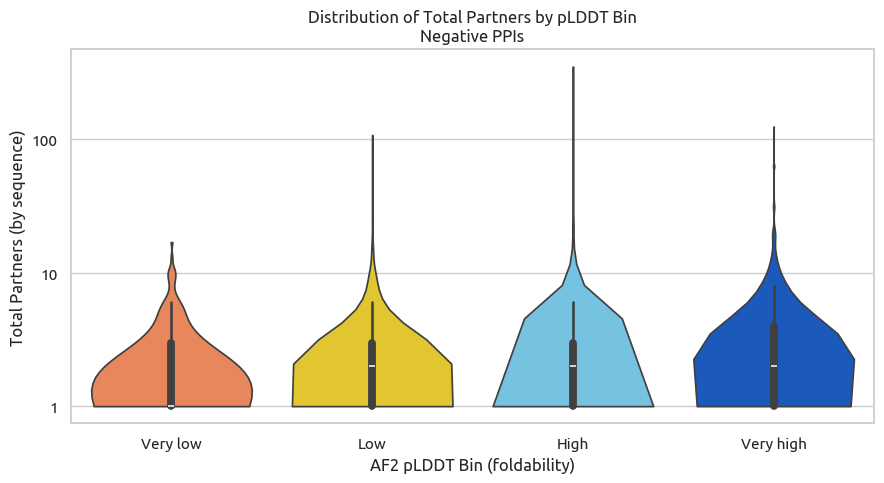

/tmp/ipykernel_317837/593959527.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_317837/593959527.py:32: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


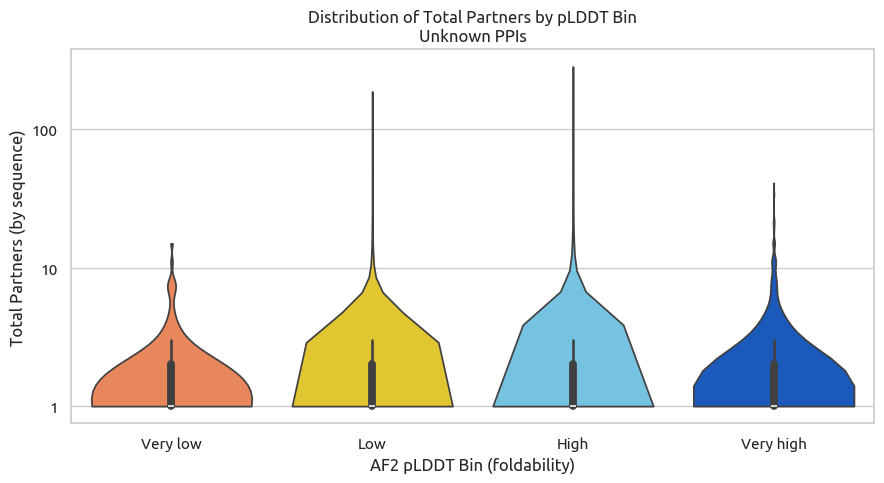

In [ ]:
make_partner_distribution_plot(afdb_stats_merge_pos, ppi_type="Positive")
make_partner_distribution_plot(afdb_stats_merge_neg, ppi_type="Negative")
make_partner_distribution_plot(afdb_stats_merge_unknown, ppi_type="Unknown")


# Protein-protein vs. protein-peptide

In [ ]:
pos["mol_types"] = pos[["mol_type_1","mol_type_2"]].apply(lambda x: sorted([x["mol_type_1"],x["mol_type_2"]]), axis=1)
pos["mol_types"] = pos["mol_types"].apply(lambda x: "-".join(x))
pos[["mol_type_1","mol_type_2","mol_types"]]
type_counts_pos = pos.groupby("seq_sort").agg(
    mol_types = ("mol_types",lambda x: ",".join(sorted(list(set(x))))),
    tot_mol_types = ("mol_types","nunique")
)
type_counts_pos["mol_types"] = type_counts_pos["mol_types"].apply(lambda x: "peptide-protein" if x=="peptide-protein,protein-protein" else x)
type_counts_pos["tot_mol_types"] = type_counts_pos["mol_types"].apply(lambda x: len(x.split(",")))
test1 = len(type_counts_pos.loc[type_counts_pos["tot_mol_types"]!=1])==0
print(f"Each seq-sort has exactly one mol_type combination: {test1}")
type_counts_pos = type_counts_pos["mol_types"].value_counts().reset_index()
type_counts_pos["ppi_sign"] = "positive"
display(type_counts_pos)

Each seq-sort has exactly one mol_type combination: True


,mol_types,count,ppi_sign
0,protein-protein,462482,positive
1,peptide-protein,918,positive
2,peptide-peptide,4,positive


In [ ]:
neg["mol_types"] = neg[["mol_type_1","mol_type_2"]].apply(lambda x: sorted([x["mol_type_1"],x["mol_type_2"]]), axis=1)
neg["mol_types"] = neg["mol_types"].apply(lambda x: "-".join(x))
neg[["mol_type_1","mol_type_2","mol_types"]]
type_counts_neg = neg.groupby("seq_sort").agg(
    mol_types = ("mol_types",lambda x: ",".join(sorted(list(set(x))))),
    tot_mol_types = ("mol_types","nunique")
)
type_counts_neg["mol_types"] = type_counts_neg["mol_types"].apply(lambda x: "peptide-protein" if x=="peptide-protein,protein-protein" else x)
type_counts_neg["tot_mol_types"] = type_counts_neg["mol_types"].apply(lambda x: len(x.split(",")))
test1 = len(type_counts_neg.loc[type_counts_neg["tot_mol_types"]!=1])==0
print(f"Each seq-sort has exactly one mol_type combination: {test1}")
type_counts_neg = type_counts_neg["mol_types"].value_counts().reset_index()
type_counts_neg["ppi_sign"] = "negative"
display(type_counts_neg)

Each seq-sort has exactly one mol_type combination: True


,mol_types,count,ppi_sign
0,protein-protein,13805,negative
1,peptide-protein,226,negative


In [ ]:
unknown["mol_types"] = unknown[["mol_type_1","mol_type_2"]].apply(lambda x: sorted([x["mol_type_1"],x["mol_type_2"]]), axis=1)
unknown["mol_types"] = unknown["mol_types"].apply(lambda x: "-".join(x))
unknown[["mol_type_1","mol_type_2","mol_types"]]
type_counts_unknown = unknown.groupby("seq_sort").agg(
    mol_types = ("mol_types",lambda x: ",".join(sorted(list(set(x))))),
    tot_mol_types = ("mol_types","nunique")
)
type_counts_unknown["mol_types"] = type_counts_unknown["mol_types"].apply(lambda x: "peptide-protein" if x=="peptide-protein,protein-protein" else x)
type_counts_unknown["tot_mol_types"] = type_counts_unknown["mol_types"].apply(lambda x: len(x.split(",")))
test1 = len(type_counts_unknown.loc[type_counts_unknown["tot_mol_types"]!=1])==0
print(f"Each seq-sort has exactly one mol_type combination: {test1}")
type_counts_unknown = type_counts_unknown["mol_types"].value_counts().reset_index()
type_counts_unknown["ppi_sign"] = "unknown"
display(type_counts_unknown)

Each seq-sort has exactly one mol_type combination: True


,mol_types,count,ppi_sign
0,protein-protein,9955,unknown
1,peptide-protein,415,unknown


In [ ]:
# combine!
type_counts = pd.concat([
    type_counts_pos.rename(
        columns={"mol_types":"interaction_type"}
    ),
    type_counts_neg.rename(
        columns={"mol_types":"interaction_type"}
    ),
    type_counts_unknown.rename(
        columns={"mol_types":"interaction_type"}
    ),
    pd.DataFrame(
        data={"interaction_type":["peptide-peptide","peptide-peptide"],"count":[0,0],"ppi_sign":["negative","unknown"]}
    )
]).reset_index(drop=True)
display(type_counts)

,interaction_type,count,ppi_sign
0,protein-protein,462482,positive
1,peptide-protein,918,positive
2,peptide-peptide,4,positive
3,protein-protein,13805,negative
4,peptide-protein,226,negative
5,protein-protein,9955,unknown
6,peptide-protein,415,unknown
7,peptide-peptide,0,negative
8,peptide-peptide,0,unknown


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_ppi_type_bars(df_counts, add_labels=True):
    """
    Grouped bar plot of Protein–protein vs Peptide–protein interactions.

    Expected columns in df_counts:
      - 'interaction_type': 'protein-protein' or 'protein-peptide' or 'peptide-peptide
      - 'ppi_sign': 'positive', 'negative', or 'unknown'
      - 'count': integer

    Example structure:
        interaction_type   ppi_sign   count
        protein-protein    positive   123
        protein-protein    negative   45
        protein-protein    unknown    67
        protein-peptide    positive   89
        protein-peptide    negative   10
        protein-peptide    unknown    11
    """

    # Ensure types / ordering
    interaction_order = ["protein-protein", "peptide-protein","peptide-peptide"]
    sign_order = ["positive", "negative", "unknown"]

    # colors: blue, orange, grey
    color_map = {
        "positive": "#1f77b4",  # blue
        "negative": "#ff7f0e",  # orange
        "unknown":  "#7f7f7f",  # grey
    }

    # Pivot to 2 x 3 matrix (rows: interaction_type, cols: ppi_sign)
    table = (
        df_counts
        .pivot_table(index="interaction_type", columns="ppi_sign", values="count", fill_value=0)
        .reindex(index=interaction_order, columns=sign_order)
    )

    set_font()  # your Ubuntu font helper, if you have it
    fig, ax = plt.subplots(figsize=(7, 5))

    n_groups = len(interaction_order)   # 2
    n_bars = len(sign_order)            # 3
    x = np.arange(n_groups)
    width = 0.22                        # width of each bar

    # Plot each sign as an offset
    for i, sign in enumerate(sign_order):
        counts = table[sign].values
        ax.bar(
            x + (i - 1) * width,    # center them around each group
            counts,
            width=width,
            label=sign.capitalize() + " PPIs",
            color=color_map[sign]
        )

        # Optional labels on top of each bar
        if add_labels:
            for xi, c in zip(x + (i - 1) * width, counts):
                ax.text(
                    xi,
                    c,
                    f"{int(c):,}",
                    ha="center",
                    va="bottom",
                    fontsize=9,
                    rotation=0
                )

    # Axes / labels
    ax.set_xticks(x)
    ax.set_xticklabels(["Protein–protein", "Peptide–protein","Peptide-peptide"])
    ax.set_ylabel("Number of interactions")
    ax.set_title("Interaction counts by type and sign")

    ax.legend(title="Interaction sign", frameon=True)

    plt.tight_layout()
    plt.show()


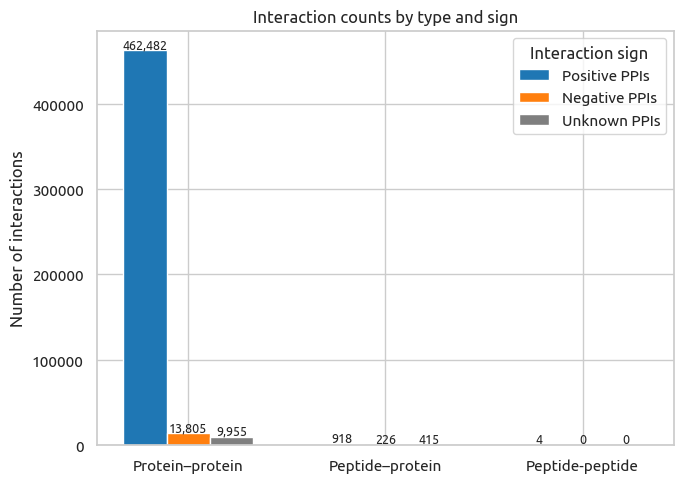

In [ ]:
# example: df_counts has the 6 rows (2×3 combos)
plot_ppi_type_bars(type_counts)


# Length distribution
Make plots of the lengths of the partners (separate prpotein and peptide)
perhaps histograms 

# Species distribution

# MI term interaction type distribution

# Triplet, quadruplet, quintuplet, etc. construction options
Investigate based on the current groupings that we have, how many proteins are valid contenders for fully evidenced triplets, quadruplets, etc.

# ESM pPL test for shuffled proteins

In [ ]:
from transformers import AutoModelForMaskedLM, AutoTokenizer
esm2 = AutoModelForMaskedLM.from_pretrained("facebook/esm2_t33_650M_UR50D").to("cuda")
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")

In [ ]:
import torch
def compute_esm2_ppl(model, tokenizer, sequence):
    """
    Compute pPL by sequentially masking and unmasking each residue in a protein
    Adapted from PepMLM code by Leo Chen.
    """
    # 
    input_ids = tokenizer.encode(sequence, return_tensors="pt").to(model.device)
    L = len(sequence)

    masked_inputs = input_ids.repeat(L, 1).to(model.device)
    positions_to_mask = torch.arange(-L - 1, -1)  # mask one by one
    masked_inputs[torch.arange(L), positions_to_mask] = tokenizer.mask_token_id # mask one position at a time and unmask it
    labels = torch.full_like(masked_inputs, -100).to(model.device)   # labels are -100 except at the masked position which we are predicting
    # Example for length 3. At (0,-4), (1,-3), (2,-2), fill in the input ids. everything else left as -100
    labels[torch.arange(L), positions_to_mask] = input_ids[0, positions_to_mask]    # labels are the original ids just at the positions we masked

    with torch.no_grad():
        # calculate the cross-entropy loss, comparing the logits to the labels 
        loss = esm2(masked_inputs, labels=labels).loss
        # exponentiate the loss to get ppl
        ppl = float(np.exp(loss.item()))
        
    return ppl    

In [ ]:
import random

def deterministic_shuffle(seq, seed=42):
    rng = random.Random(seed)
    lst = list(seq)
    shuffle=seq
    while seq==shuffle:
        rng.shuffle(lst)
        shuffle = "".join(lst) 
    return shuffle


In [ ]:
# compute ppl for a real protein versus a shuffled one
real_protein = pos.sample(1, random_state=42)["aa_1"].item()
print(f"Real protein: {real_protein}\nLength: {len(real_protein)} AAs")
ppl_real = compute_esm2_ppl(esm2, tokenizer, real_protein)

shuffled_protein = deterministic_shuffle(real_protein)
print(f"Shuffled protein: {shuffled_protein}\nLength: {len(shuffled_protein)}")
ppl_shuffled = compute_esm2_ppl(esm2, tokenizer, shuffled_protein)

print(f"pPL real: {ppl_real}\tpPL shuffled: {ppl_shuffled}")

Real protein: MGLVVSATASCSDIFFSRRRSSSPPPPAAASTPPPTYTIPEPALVRVFRHFDADGDGRISADEMRELCGCTAVEADEMVAVADRDGDGFISLEELEALFEDGDRSDTLRAAFAEYDENGDGVITAEELRRALWRLGIVGEEMTAERCAEMIAVVDIDGDGVVCFDEFKAMMDTAAAS
Length: 177 AAs
Shuffled protein: EYFAIDRVRRDAPLERVGKDITVSAAATHDDVCGLLVRMFSEDDSEEIELMWAGRVDILPAFDAGELRPRFIMEVVATGDAVDSPAEEGAVCLGSEMSDRIPGERFGVTAIMRDAGACTFADSDSVEEDSATNSCFLPLCMDVPMGEEGAIYGLAFAADRSDPTARASEPTRETAAF
Length: 177
pPL real: 5.168914802048042	pPL shuffled: 17.741541224870673


In [ ]:
# try this 1000 times
def esm_shuffle_test(sequences):
    results = []
    # compute ppl for a real protein versus a shuffled one
    for real_protein in sequences:
        ppl_real = compute_esm2_ppl(esm2, tokenizer, real_protein)

        shuffled_protein = deterministic_shuffle(real_protein)
        ppl_shuffled = compute_esm2_ppl(esm2, tokenizer, shuffled_protein)
        results.append({
            "real":real_protein,
            "shuffled":shuffled_protein,
            "ppl_real": ppl_real,
            "ppl_shuffled": ppl_shuffled
        })
    return results
        
real_proteins = pos.loc[pos["length_1"]<500].drop_duplicates("aa_1")
real_proteins = real_proteins.sample(10, random_state=42)["aa_1"].unique().tolist()
print([len(x) for x in real_proteins])
esm_shuffle_results = esm_shuffle_test(real_proteins)

[324, 264, 138, 108, 179, 356, 166, 329, 353, 379]


In [ ]:
df = pd.DataFrame(esm_shuffle_results)
display(df)

,real,shuffled,ppl_real,ppl_shuffled
0,MSIAIIIGTHGAAAEQLLKTAEMILGEQSNVAYIDFVPGENAETLI...,YVGPLKWESAIKKTVATAGHLIMIDPSPNSVVDNETKNIAPAKIGG...,3.034816,18.297820
1,MAFAVSDELLGTFVPIAVYWLYSGLYVVLDGLGMDDYRLHPKGEEE...,MATSSQGFLKMSDNVYRLHLVSHLQDFFLGEAAKFGRDRTVPILVV...,2.178777,19.192952
2,MQLPPFDMWKDYFNLSQVVWALIASQGQRLETQEIEEPSPGPPLGQ...,ANKKAQVVVNQRCQKYCTVGLYGEKAPELLQGRLNLQGLTSYLHPG...,8.511673,19.123377
3,MVNLGLSRVDDAVAAKHPGLGEYAACQSHAFMKGVFTFVTGTGMAF...,LDVVSKSVCQKSFKVAQSVFLLGGSRWVEFAGDPFDQSTPMRTFLT...,9.264124,19.919663
4,MAGNPDNVVLWTEADVLFYNSATLPVEDIPESITDPFVTTTGKWGY...,DDVKAFEEWNDEPGLSANEIPVVRKVQILNDAGSGKWDMMSLKSLT...,9.695395,19.469557
5,ASSKTEIKPLLKFIYQNLSRVNLKLKSVTVFSDRSLLNDVETSSSE...,NELTPMHTESARSLESDAHLEYKSNVTEIASTSQSAVKIVDNKALT...,5.175555,17.496013
6,MSTTEAVVIKVGIADVKIARFPDTIRTSGLGSCVGLVLYDKEKQTA...,ADLLFSEIELYGKETGHRQQFVTMILTQRGPAAESQTKTCPDPAAN...,4.082359,19.168701
7,MGRTSKDKRDVYYRLAKENGWRARSAFKLLQLDKEFQLFQGVTRAV...,DLFQYLRDAYKGPGLYDHFDFLMTGLDAPGSNQSPINCGPFAINAL...,3.733945,18.337378
8,MEKTLETVPLERKKREKEQFRKLFIGGLSFETTEESLRNYYEQWGK...,YGGFRGGNPEKPNHGVRGGGEGAMGVGFGQSGNERVVSSGQGERRR...,4.237299,16.396758
9,MGYARKVGWVTAGLVIGAGACYCIYRLTRGRKQNKEKMAEGGSGDV...,VDGKFSIEFNAFLFAMLVRARITFDDLAGTLGCDSLLCSAILEVPR...,6.788340,18.859526


In [ ]:
# I'm curious if these proteins also lie in a different part of the protein space than the originals
print(len(esm_shuffle_results))

10


# Investigate binding sites
I want to know if I have isoform-specificity or if I can invent it by taking cases where I have a binding site and then look if that binding site still exists in a different isoform. This is incredibly important to do. 

Criteria: certain amount of homology but lacking that binding site (if same isoform). Also make sure it contains no known "necessary binding regions" or "sufficient binding regions" for that partner
Include fusions in the list of things I'm checking as potentailly will still bind or not bind. 

In [ ]:
binding_related_cols = [x for x in pos if x.startswith("all_binding")]
display(pos[binding_related_cols])

,all_binding_mi_1,all_binding_name_1,all_binding_short_1,all_binding_begin_1,all_binding_end_1,all_binding_mi_2,all_binding_name_2,all_binding_short_2,all_binding_begin_2,all_binding_end_2
0,MI:0117,binding-associated region,binding site,295,386,MI:0117,binding-associated region,binding site,49,63
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MI:0117,binding-associated region,binding site,1,86,MI:0117,binding-associated region,binding site,70,84
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
48228,MI:0442,sufficient binding region,ecd,18,615,MI:0442,sufficient binding region,ecd,1,1208
48229,MI:0442,sufficient binding region,ecd,18,615,MI:0442,sufficient binding region,ecd,1,1208
48230,MI:0442,sufficient binding region,ecd,18,615,MI:0442,sufficient binding region,ecd,1,1208
48231,MI:0442,sufficient binding region,ecd,18,615,MI:0442,sufficient binding region,ecd,1,1208
